In [2]:
!python3 -m ipykernel install --user --name=python11_env

Installed kernelspec python11_env in /mnt/zfsusers/hollowayp/.local/share/jupyter/kernels/python11_env


In [ ]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import astropy.units as U
import sys
import os
sim_pipeline_path = '/mnt/zfsusers/hollowayp/sim-pipeline/'
paltas_path = '/mnt/zfsusers/hollowayp/paltas/'
sys.path.append(sim_pipeline_path)
sys.path.append(paltas_path)
os.chdir(sim_pipeline_path)
#sys.path.append('/global/homes/p/phil1884/')
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots

from Load_LensPop_LSST_db import db_LensPop_LSST
import matplotlib.pyplot as pl
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import os

from scipy.stats import norm, truncnorm, uniform
from matplotlib.colors import Normalize, LogNorm
from plot_image_collage import plot_collage
import glob
from scipy.optimize import curve_fit

def set_max_pd(rows=None,columns=None):
    pd.set_option('display.max_columns', columns)
    pd.set_option('display.max_rows', rows)

set_max_pd(rows=30,columns=30)

#Adding in random, uniformly distributed lens position angles for LensPop, so ellipticities can be calculated:
np.random.seed(1)
def generate_LensPop_PA(db):
    return np.pi*np.random.random(size=len(db)) #Returning position angle, in radians

PA_LensPop_New = generate_LensPop_PA(db_LensPop_LSST)
db_LensPop_LSST['PA_lens'] = PA_LensPop_New

from Ellipticities_Translation import EllipticitiesTranslation

db_LensPop_e1,db_LensPop_e2 = EllipticitiesTranslation(db_LensPop_LSST['PA_lens'],db_LensPop_LSST['q_lens_flat'])
db_LensPop_LSST['e1_lens'] = db_LensPop_e1
db_LensPop_LSST['e2_lens'] = db_LensPop_e2

import arviz as az
az.style.use("arviz-doc")


# Load Kernel

In [1]:
import sys
import dill
paltas_path = '/mnt/zfsusers/hollowayp/paltas/'
sim_pipeline_path = '/mnt/zfsusers/hollowayp/sim-pipeline/'
sys.path.append(paltas_path)
sys.path.append(sim_pipeline_path)
dill.load_session('/mnt/zfsusers/hollowayp/sim-pipeline/notebooks/galaxy_galaxy_lensing_tutorial.db')

/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Save Kernel

In [19]:
import dill
dill.dump_session('/mnt/zfsusers/hollowayp/sim-pipeline/notebooks/galaxy_galaxy_lensing_tutorial.db')

In [88]:
print({elem:np.round(np.percentile(db_LensPop_LSST['zL'],elem),3) for elem in [1,0.5,0.68,90,99]})
print({elem:np.round(np.percentile(db_LensPop_LSST['zS'],elem),3) for elem in [1,0.5,0.68,90,99]})
print({elem:np.round(np.percentile(db_LensPop_LSST['i_lens'],elem),3) for elem in [1,0.5,0.68,90,99]})
print({elem:np.round(np.percentile(db_LensPop_LSST['i_source']-2.5*np.log10(db_LensPop_LSST['mu_s']),elem),3) for elem in [1,0.5,0.68,90,99]})

db_LensPop_LSST[['zL','zS','i_lens']].describe()

{1: 0.094, 0.5: 0.078, 0.68: 0.084, 90: 0.83, 99: 1.246}
{1: 0.597, 0.5: 0.523, 0.68: 0.548, 90: 3.239, 99: 4.565}
{1: 14.143, 0.5: 13.662, 0.68: 13.841, 90: 20.55, 99: 22.64}
{1: 20.939, 0.5: 20.443, 0.68: 20.642, 90: 24.41, 99: 24.808}


zL           zS       i_lens
count  8833.000000  8833.000000  8833.000000
mean      0.487772     2.130606    18.298127
std       0.252526     0.865020     1.769459
min       0.023000     0.210000    10.500000
25%       0.302000     1.496000    17.150000
50%       0.445000     2.070000    18.290000
75%       0.627000     2.660000    19.410000
max       1.865000     6.689000    25.440000

In [25]:
'''
Calculating a reasonable cutoff magnitude for the source population:
From here (https://www.lsst.org/scientists/keynumbers), the i-band 5-sigma point source limit is 26.4. 
The lenspop median magnification, np.median(db_LensPop_LSST['mu_s']), is 6.18 (lets call it 6.2).
If the configurations were all the same, 50% of the sources with magnitude 26.4+2.5*np.log10(6.2)=28.4 would be detectable.
Given we are currently using draws from a gaussian-sample of parameters, it is likely fewer than this will be detectable.

Calculating a reasonable cutoff magnitude for the lens magnitude:
The 99th percentile in lens redshift from Lenspop, np.percentile(db_LensPop_LSST['i_lens'],99), was 22.64. Lets call it 23.

Calculating a reasonable cutoff lens redshift:
The 99th percentile in lens redshift from Lenspop, np.percentile(db_LensPop_LSST['zL'],99), was 1.246. Lets call it 1.25

Calculating a reasonable cutoff source redshift:
The 99th percentile in source redshift from Lenspop, np.percentile(db_LensPop_LSST['zS'],99), was 4.565. Lets call it 4.6

Calculating a reasonable cutoff lensed arc brightness (total magnitude):
The 99th percentile in source redshift from Lenspop, np.percentile(db_LensPop_LSST['i_source']-2.5*np.log10(db_LensPop_LSST['mu_s']),99),
was 24.808. Lets call it 25.
'''

"\nCalculating a reasonable cutoff magnitude for the source population:\nFrom here (https://www.lsst.org/scientists/keynumbers), the i-band 5-sigma point source limit is 26.4. \nThe lenspop median magnification, np.median(db_LensPop_LSST['mu_s']), is 6.18 (lets call it 6.2).\nIf the configurations were all the same, 50% of the sources with magnitude 26.4+2.5*np.log10(6.2)=28.4 would be detectable.\nGiven we are currently using draws from a gaussian-sample of parameters, it is likely fewer than this will be detectable.\n"

# Galaxy-galaxy simulations

This notebook walks through the basics of simulating a galaxy-galaxy strong lensing population.
The underlying 

assumptions of the galaxy populations (for both lenses and sources) are drawn from a population pre-configured

 and rendered through [SkyPy](https://github.com/skypyproject/skypy). The specific settings are described in the [readme file](https://github.com/LSST-strong-lensing/sim-pipeline/tree/gg-lensing/data/SkyPy).

The notebook goes in three steps:

1. The populations of lenses and sources is produced.
2. Random draws of the population are generated and realized as images
3. The full population is generated in catalogue form
4. the full population is represented in a corner plot



## Generate population of galaxies and (potential) deflectors
The GalaxyGalaxyLensPop() class in the sim-pipeline package is used to produce a set of galaxies (as lenses and sources)

as seen on the sky within a certain sky area.
We use the default SkyPy configuration file. Alternative configuration

files can be used.

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from importlib import reload  # Python 3.4+
reload(sys.modules['slsim'])
reload(sys.modules['slsim.lens_pop'])
from slsim.lens_pop import LensPop

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=2, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 23, "z_min": 0.01, "z_max": 1.26}
#magnitude limit set by median Lenspop magnification, and 5-sigma point-source limit:
kwargs_source_cut = {"band": "i", "band_max": 28.4, "z_min": 0.1, "z_max": 4.6}

# run skypy pipeline and make galaxy-galaxy population class using GalaxyGalaxyLensPop
gg_lens_pop = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=sim_pipeline_path+'/data/SkyPy/lsst-like.yml',
    sky_area=sky_area,
    cosmo=cosmo,
)
print('IMPORTANT NOTE: SIM-PIPELINE DEFINES A COSMOLOGY IN ITS SKYPY CONFIG FILE, HERE https://github.com/LSST-strong-lensing/slsim/blob/gg-lensing/data/SkyPy/lsst-like.yml'+\
    'THIS WILL NEED TO BE CORRECTED TO THE COSMOLOGY I AM TRYING TO RETRIEVE, BEFORE DOING POPULATION-LEVEL ANALYSIS.')
print('SECOND IMPORTANT NOTE: WE HAVE JUST DEFINED A COSMOLOGY TO GENERATE gg_lens_pop. MAKE SURE THIS IS THE RIGHT COSMOLOGY!!!!')

IMPORTANT NOTE: SIM-PIPELINE DEFINES A COSMOLOGY IN ITS SKYPY CONFIG FILE, HERE https://github.com/LSST-strong-lensing/slsim/blob/gg-lensing/data/SkyPy/lsst-like.ymlTHIS WILL NEED TO BE CORRECTED TO THE COSMOLOGY I AM TRYING TO RETRIEVE, BEFORE DOING POPULATION-LEVEL ANALYSIS.
SECOND IMPORTANT NOTE: WE HAVE JUST DEFINED A COSMOLOGY TO GENERATE gg_lens_pop. MAKE SURE THIS IS THE RIGHT COSMOLOGY!!!!


`gg_lens_pop` is an object that contains information about galaxies lensed by other galaxies. It has the following attributes:
1. deflector_number()
2. source_number()

In [3]:
gg_lens_pop

# Importing External Datasets

In [3]:

Grillo_2008 = pd.read_csv('/mnt/zfsusers/hollowayp/paltas/Project_2_Data/Grillo_2008_Table_1&4.tsv',delimiter=';',skiprows=119,
names=['SLACS','zl','zs','thetaE','thetae','SDSS','Sloan','Simbad',
    'MSalBC (10_10M_sol)','E_MSalBC (10_10M_sol)','e_MSalBC (10_10M_sol)',
    'MSalM (10_10M_sol)','E_MSalM (10_10M_sol)','e_MSalM (10_10M_sol)',
    'MChaBC (10_10M_sol)','E_MChaBC (10_10M_sol)','e_MChaBC (10_10M_sol)',
    'MKroM (10_10M_sol)','E_MKroM (10_10M_sol)','e_MKroM (10_10M_sol)','fap',
    'MSalBC_Rein (10_10M_sol)','E_MSalBC_Rein (10_10M_sol)','e_MSalBC_Rein (10_10M_sol)',
    'MSalM_Rein (10_10M_sol)','E_MSalM2 (10_10M_sol)','e_MSalM_Rein (10_10M_sol)',
    'MChaBC_Rein (10_10M_sol)','E_MChaBC_Rein (10_10M_sol)','e_MChaBC_Rein',
    'MKroM_Rein (10_10M_sol)','E_MKroM_Rein (10_10M_sol)','e_MKroM_Rein (10_10M_sol)',
    'Mtotlen (10_10M_sol)','e_Mtotlen (10_10M_sol)',
    '_RA','_DE'])
Bolton_2008 = pd.read_csv('/mnt/zfsusers/hollowayp/paltas/Project_2_Data/Bolton_2008_SLACS_V_Table_4.tsv',delimiter=';',skiprows=79,
names=['SDSS','zFG','zBG','Imag','n_Imag','Name','L(V555)','Re','b/a','sigma','e_sigma','Mph','Mul','Lens','n_Lens','Sloan','_RA','_DE'])

'''
Important notes about this sample:
1) There are many different options for stellar mass, depending on which IMF etc is chosen.
2) Some systems don't have available velocity dispersions.
3) These are only the high-grade SLACS systems (~50 of them)
4) The velocity dispersions have NOT been aperture corrected.
'''
SLACS_A_Grade_db = pd.merge(Grillo_2008,Bolton_2008,left_on='SLACS',right_on='Name')
SLACS_A_Grade_db=SLACS_A_Grade_db
SLACS_A_Grade_db.replace(' ', '',inplace=True,regex=True)
SLACS_A_Grade_db.replace('', np.nan,inplace=True,regex=True)

SLACS_A_Grade_db[['Name','zl','zFG','zs','zBG','sigma','Re','MSalM (10_10M_sol)','MSalBC (10_10M_sol)']]

#Importing SL2S Sample (see /mnt/zfsusers/hollowayp/paltas/Project_2_Data/SL2S_SLACS_Lens_Properties_Notebook.ipynb)
SL2S_db = pd.read_csv('/mnt/zfsusers/hollowayp/paltas/Project_2_Data/Sonnenfeld_2013_SL2S_III_and_IV.csv')

#Importing Bezanson (2015) data:
bz_2015 = pd.read_csv(f'{paltas_path}//Bezanson_2015_Table_1.tsv',skiprows=75,header=None,delimiter=';',
                    names=['ID','RAJ2000','DEJ2000','z','Re','n','Filter','logM','sig.A','e_sig.A','sig.Re','e_sig.Re','tExp','HCat','Sloan','SimbadName'])


In [57]:
bz_2015

ID     RAJ2000   DEJ2000      z   Re    n      Filter   logM  sig.A  \
0    C1971   150.103580  2.197926  0.682  4.4  4.7  WFC3-F160W  10.96    214   
1    C2335   150.096590  2.205227  0.424  0.8  2.7  WFC3-F160W  10.13    131   
2    C3382   150.084050  2.221891  0.560  5.9  1.5  WFC3-F160W  10.62    158   
3    C3420   150.118560  2.223079  0.839  2.1  3.3  WFC3-F160W  10.83    245   
4    C3751   150.120940  2.227110  0.733  3.6  2.9  WFC3-F160W  11.07    171   
..      ...         ...       ...    ...  ...  ...         ...    ...    ...   
98   U41224   34.256416 -5.168275  0.429  1.0  4.6  WFC3-F160W  10.00    125   
99   U41225   34.238786 -5.168077  0.821  3.3  2.2  WFC3-F160W  10.89    238   
100  U42103   34.264198 -5.161362  0.505  3.6  1.6  WFC3-F160W  10.35    155   
101  U43566   34.373569 -5.148341  0.496  3.0  4.1  WFC3-F160W  10.61    193   
102  U43091   34.296449 -5.151083  0.629  1.9  4.6  WFC3-F160W  10.61    205   

     e_sig.A  sig.Re  e_sig.Re   tExp  HCat  Sloan  \
0          8     211         8  49200     3  Sloan   
1          5     143         6  49200     3  Sloan   
2          7     152         7  49200     3  Sloan   
3         15     255        16  49200     3  Sloan   
4          7     172         7  49200     3  Sloan   
..       ...     ...       ...    ...   ...    ...   
98         9     133        10  27600     2  Sloan   
99        18     240        18  27600     2  Sloan   
100        8     153         8  27600     2  Sloan   
101        6     193         6  27600     2  Sloan   
102        6     213         7  27600     2  Sloan   

                      SimbadName  
0                     NMBS C1971  
1                     NMBS C2335  
2                     NMBS C3382  
3                     NMBS C3420  
4                     NMBS C3751  
..                           ...  
98   [VBH2012] CANDELS UDS 19884  
99   [VBH2012] CANDELS UDS 19986  
100  [VBH2012] CANDELS UDS 21353  
101  [VBH2012] CANDELS UDS 26792  
102  [VBH2012] CANDELS UDS 22989  

[103 rows x 16 columns]

ID     RAJ2000   DEJ2000      z   Re    n      Filter   logM  sig.A  \
0    C1971   150.103580  2.197926  0.682  4.4  4.7  WFC3-F160W  10.96    214   
1    C2335   150.096590  2.205227  0.424  0.8  2.7  WFC3-F160W  10.13    131   
2    C3382   150.084050  2.221891  0.560  5.9  1.5  WFC3-F160W  10.62    158   
3    C3420   150.118560  2.223079  0.839  2.1  3.3  WFC3-F160W  10.83    245   
4    C3751   150.120940  2.227110  0.733  3.6  2.9  WFC3-F160W  11.07    171   
..      ...         ...       ...    ...  ...  ...         ...    ...    ...   
98   U41224   34.256416 -5.168275  0.429  1.0  4.6  WFC3-F160W  10.00    125   
99   U41225   34.238786 -5.168077  0.821  3.3  2.2  WFC3-F160W  10.89    238   
100  U42103   34.264198 -5.161362  0.505  3.6  1.6  WFC3-F160W  10.35    155   
101  U43566   34.373569 -5.148341  0.496  3.0  4.1  WFC3-F160W  10.61    193   
102  U43091   34.296449 -5.151083  0.629  1.9  4.6  WFC3-F160W  10.61    205   

     e_sig.A  sig.Re  e_sig.Re   tExp  HCat  Sloan  \
0          8     211         8  49200     3  Sloan   
1          5     143         6  49200     3  Sloan   
2          7     152         7  49200     3  Sloan   
3         15     255        16  49200     3  Sloan   
4          7     172         7  49200     3  Sloan   
..       ...     ...       ...    ...   ...    ...   
98         9     133        10  27600     2  Sloan   
99        18     240        18  27600     2  Sloan   
100        8     153         8  27600     2  Sloan   
101        6     193         6  27600     2  Sloan   
102        6     213         7  27600     2  Sloan   

                      SimbadName  
0                     NMBS C1971  
1                     NMBS C2335  
2                     NMBS C3382  
3                     NMBS C3420  
4                     NMBS C3751  
..                           ...  
98   [VBH2012] CANDELS UDS 19884  
99   [VBH2012] CANDELS UDS 19986  
100  [VBH2012] CANDELS UDS 21353  
101  [VBH2012] CANDELS UDS 26792  
102  [VBH2012] CANDELS UDS 22989  

[103 rows x 16 columns]

In [6]:
SLSim_lenspop_nocut = gg_lens_pop.draw_population(kwargs_lens_cuts={})

Drawing Lens Systems


100%|██████████| 13559/13559 [01:36<00:00, 140.41it/s]


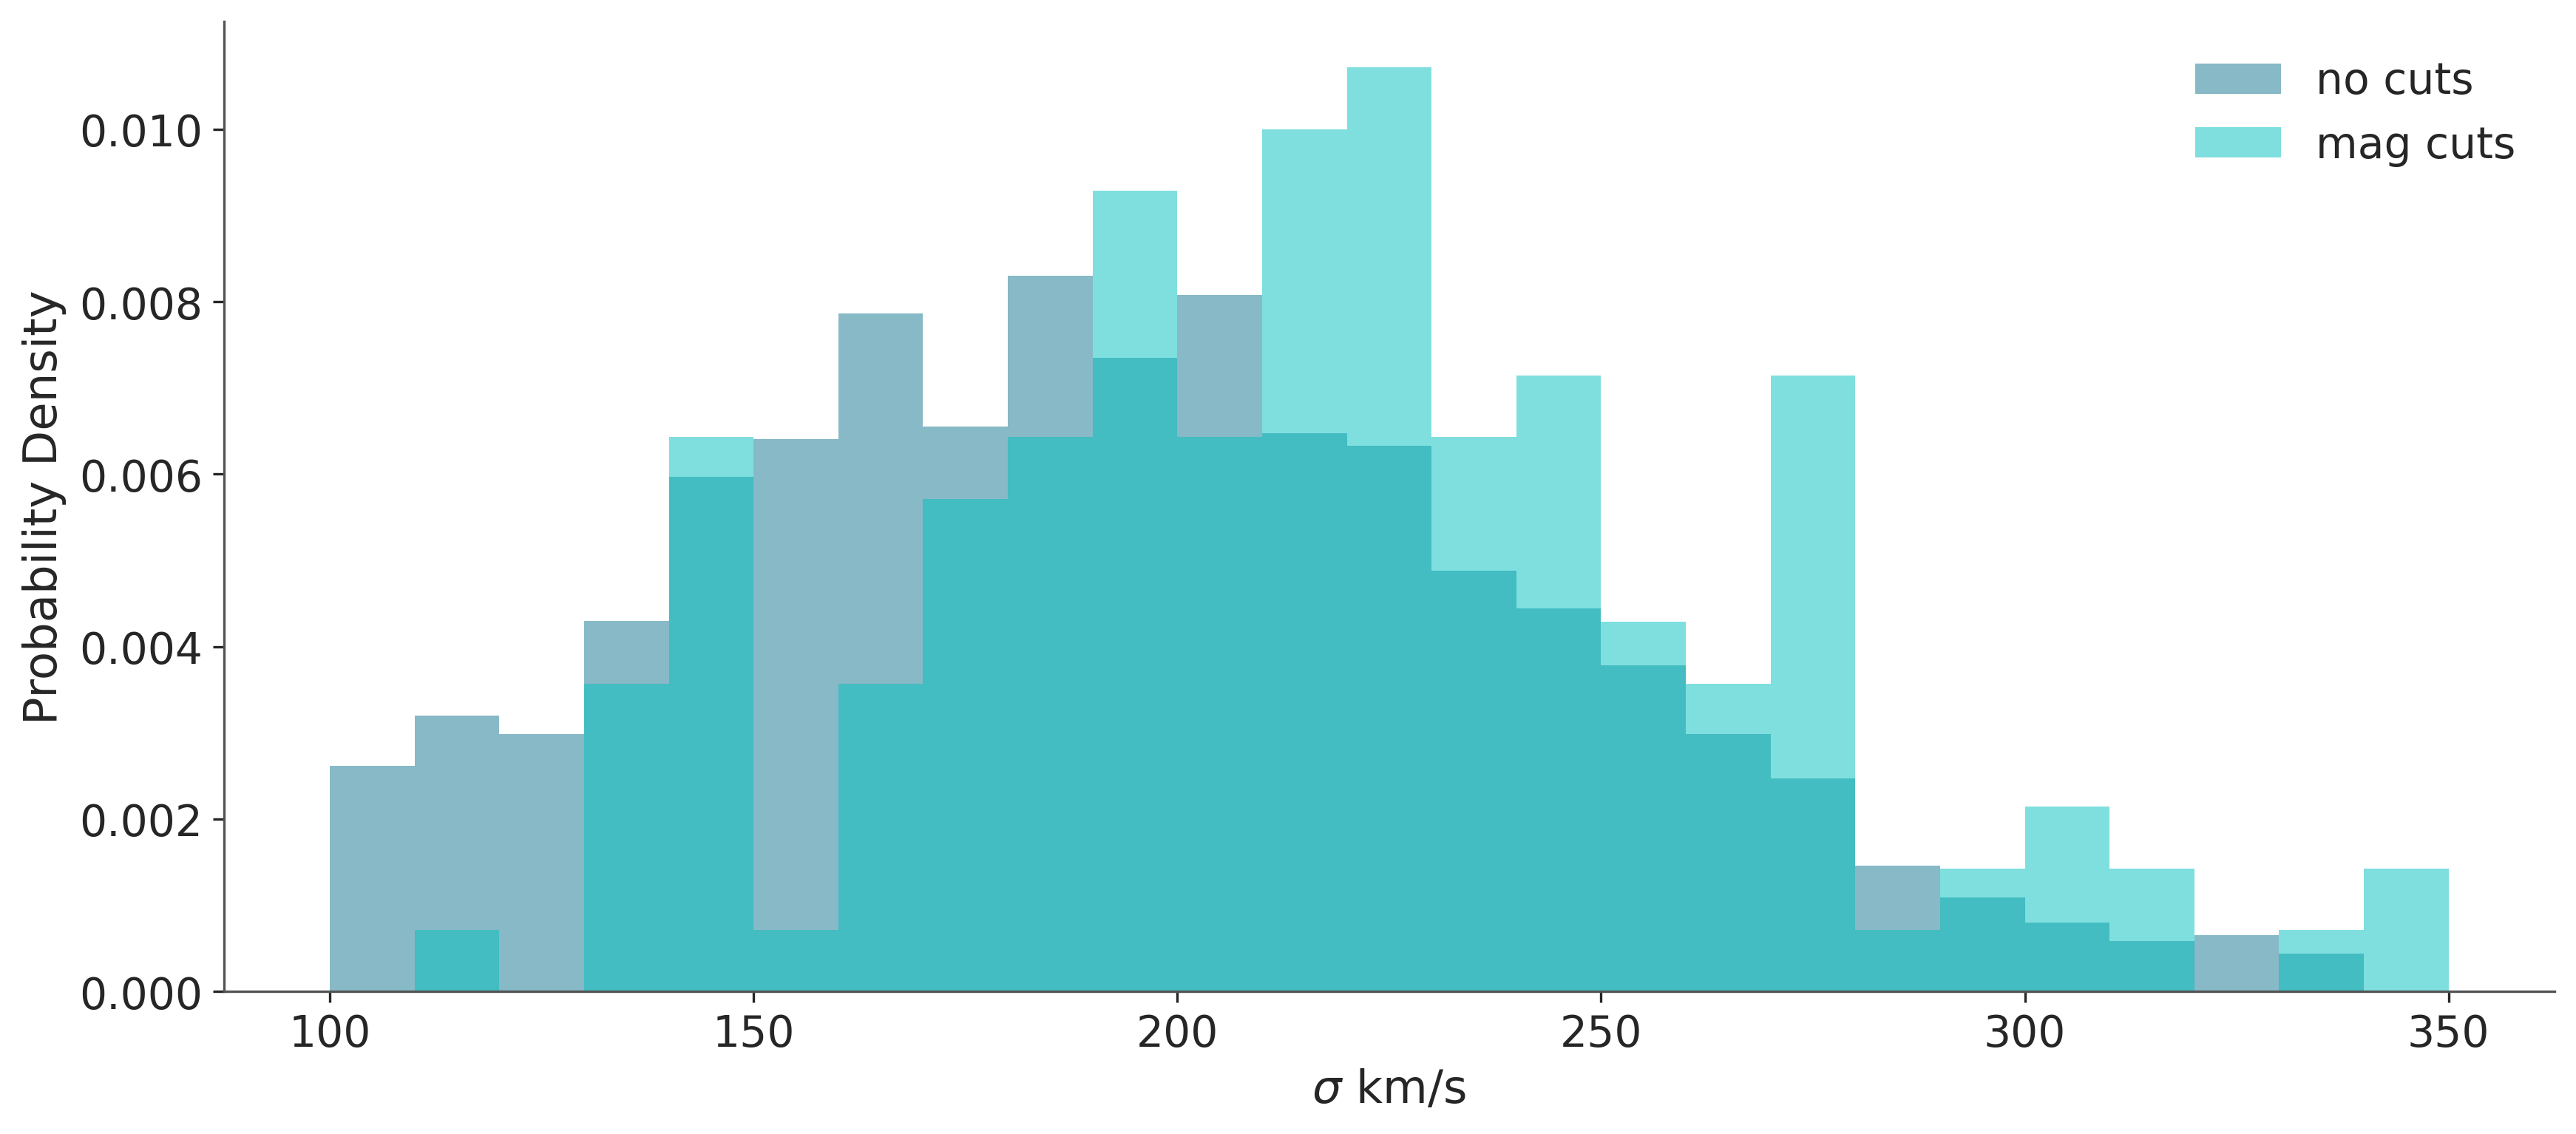

/tmp/ipykernel_47007/3801788697.py:23: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


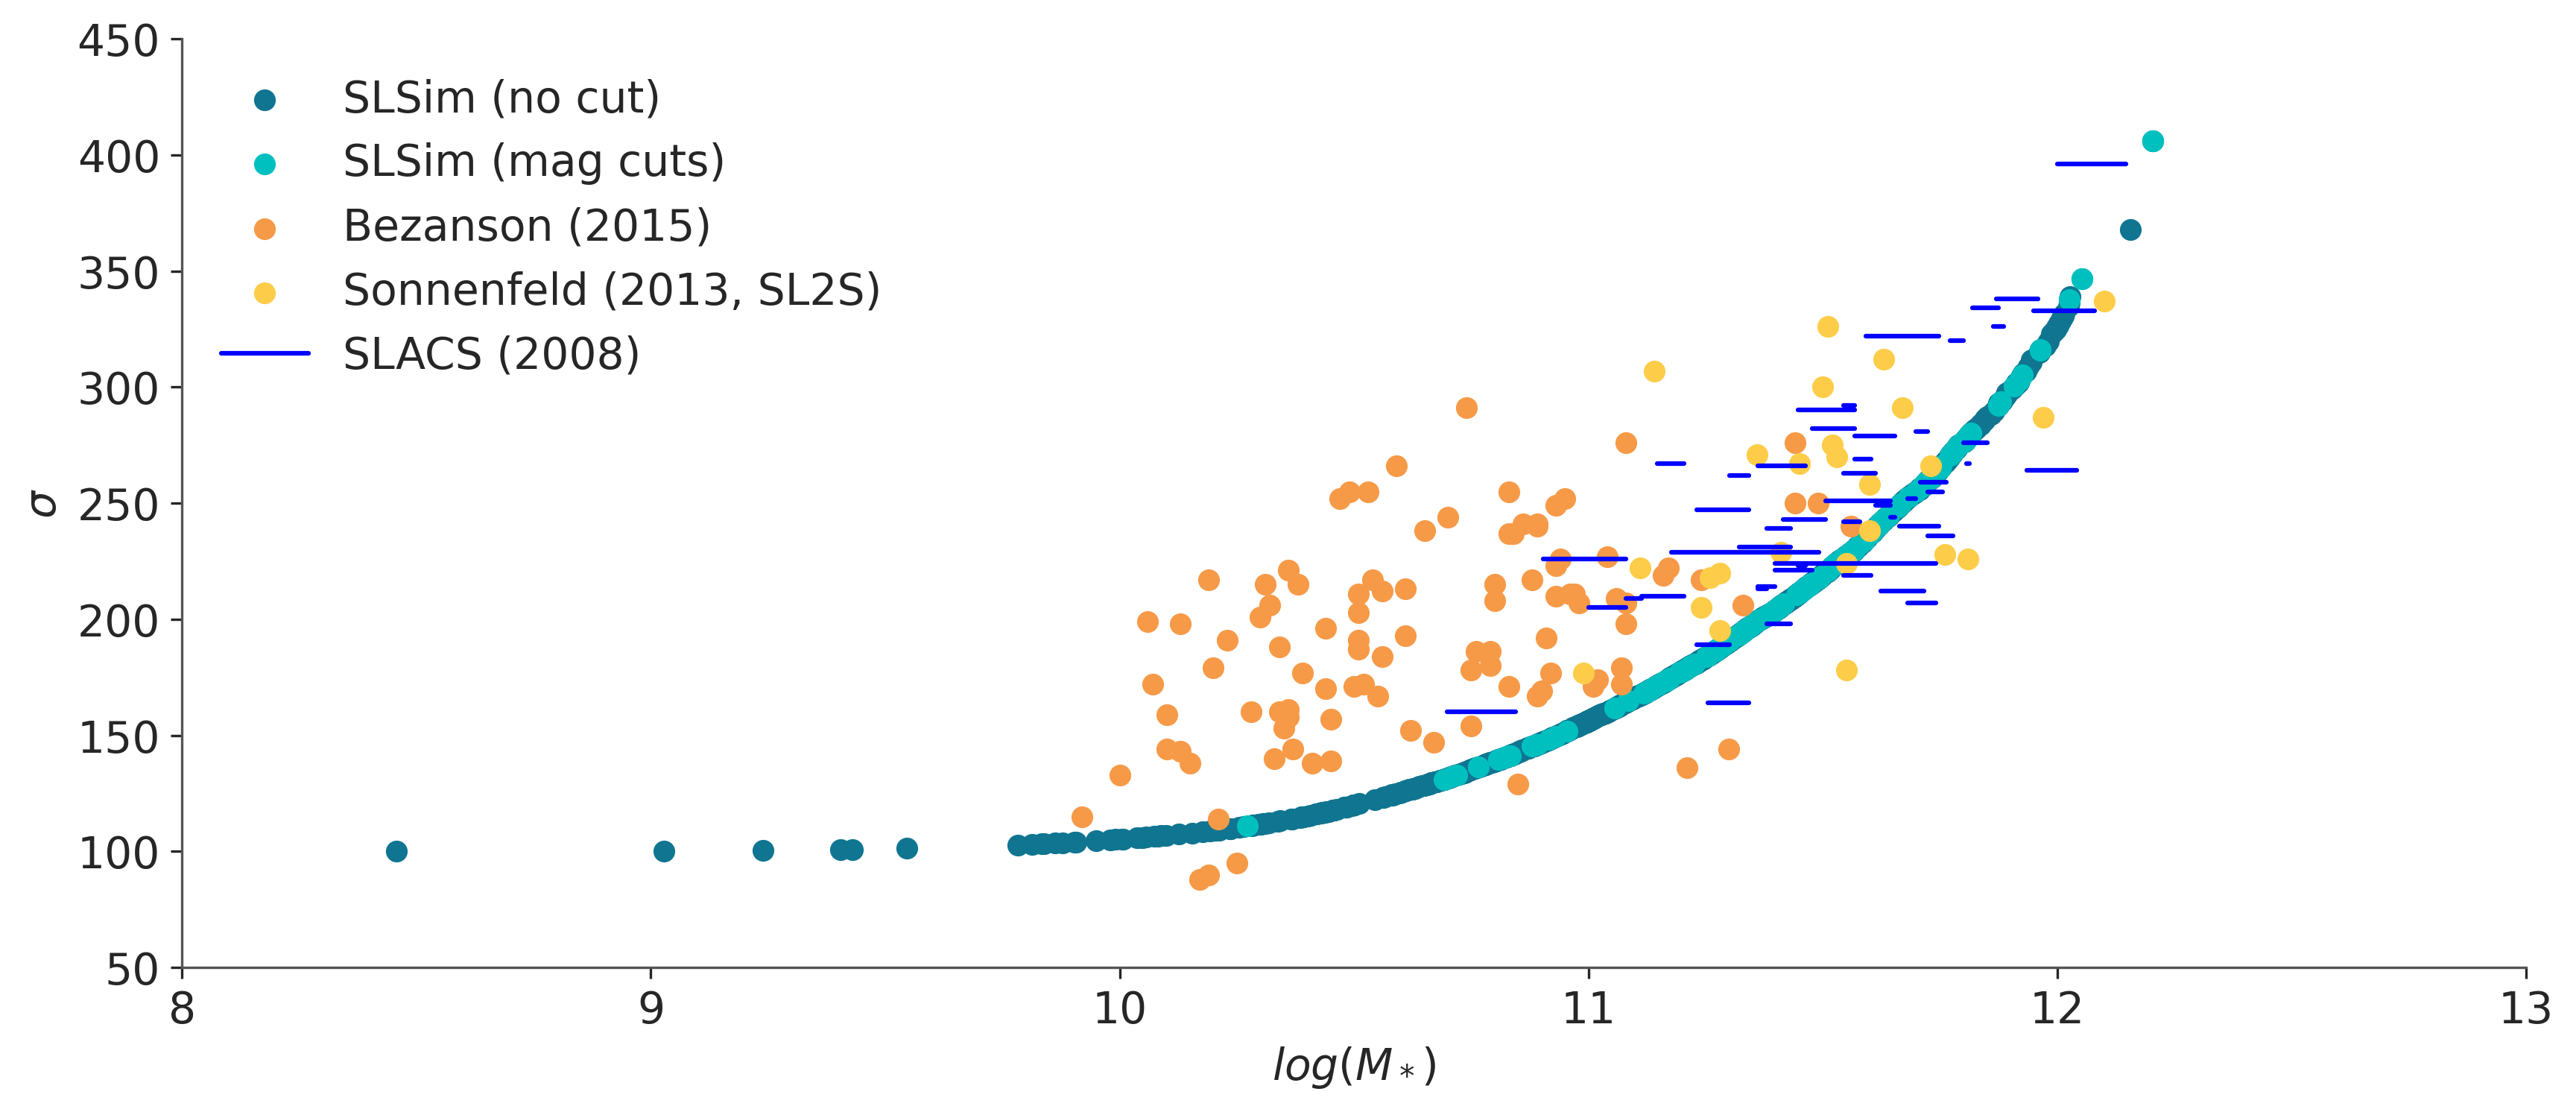

SLACS lines show difference in stellar populations for M* fit


In [7]:
#fig = pl.figure(figsize=(8,5))
hist_dict = {'bins':np.arange(100,360,10),'alpha':0.5,'density':True}
pl.hist([SLSim_lenspop_nocut[elem].deflector_velocity_dispersion() for elem in range(len(SLSim_lenspop_nocut))],**hist_dict,label='no cuts')
pl.hist([gg_lens_population[elem].deflector_velocity_dispersion() for elem in range(len(gg_lens_population))],**hist_dict,label='mag cuts')
pl.xlabel('$\sigma$ km/s',fontsize=15)
pl.ylabel('Probability Density',fontsize=15)
pl.legend()
pl.show()
pl.scatter(np.log10(np.array([SLSim_lenspop_nocut[elem].deflector_stellar_mass() for elem in range(len(SLSim_lenspop_nocut))])),
[SLSim_lenspop_nocut[elem].deflector_velocity_dispersion() for elem in range(len(SLSim_lenspop_nocut))])
pl.scatter(np.log10(np.array([gg_lens_population[elem].deflector_stellar_mass() for elem in range(len(gg_lens_population))])),
[gg_lens_population[elem].deflector_velocity_dispersion() for elem in range(len(gg_lens_population))])
pl.scatter(bz_2015['logM'],bz_2015['sig.Re'])
pl.scatter(SL2S_db['M*'],SL2S_db['O_e2'])
for s_i in range(len(SLACS_A_Grade_db)):
    pl.plot(
    [np.log10(10**10*(SLACS_A_Grade_db['MSalM (10_10M_sol)']))[s_i],np.log10(10**10*(SLACS_A_Grade_db['MSalBC (10_10M_sol)']))[s_i]],
    [SLACS_A_Grade_db['sigma'].astype('float64')[s_i],SLACS_A_Grade_db['sigma'].astype('float64')[s_i]],c='blue')

pl.xlabel('$log(M_*)$')
pl.ylabel('$\sigma$')
pl.legend(['SLSim (no cut)','SLSim (mag cuts)','Bezanson (2015)','Sonnenfeld (2013, SL2S)','SLACS (2008)'])
pl.tight_layout()
pl.xlim(8,13)
pl.ylim(50,450)
pl.show()
print('SLACS lines show difference in stellar populations for M* fit')


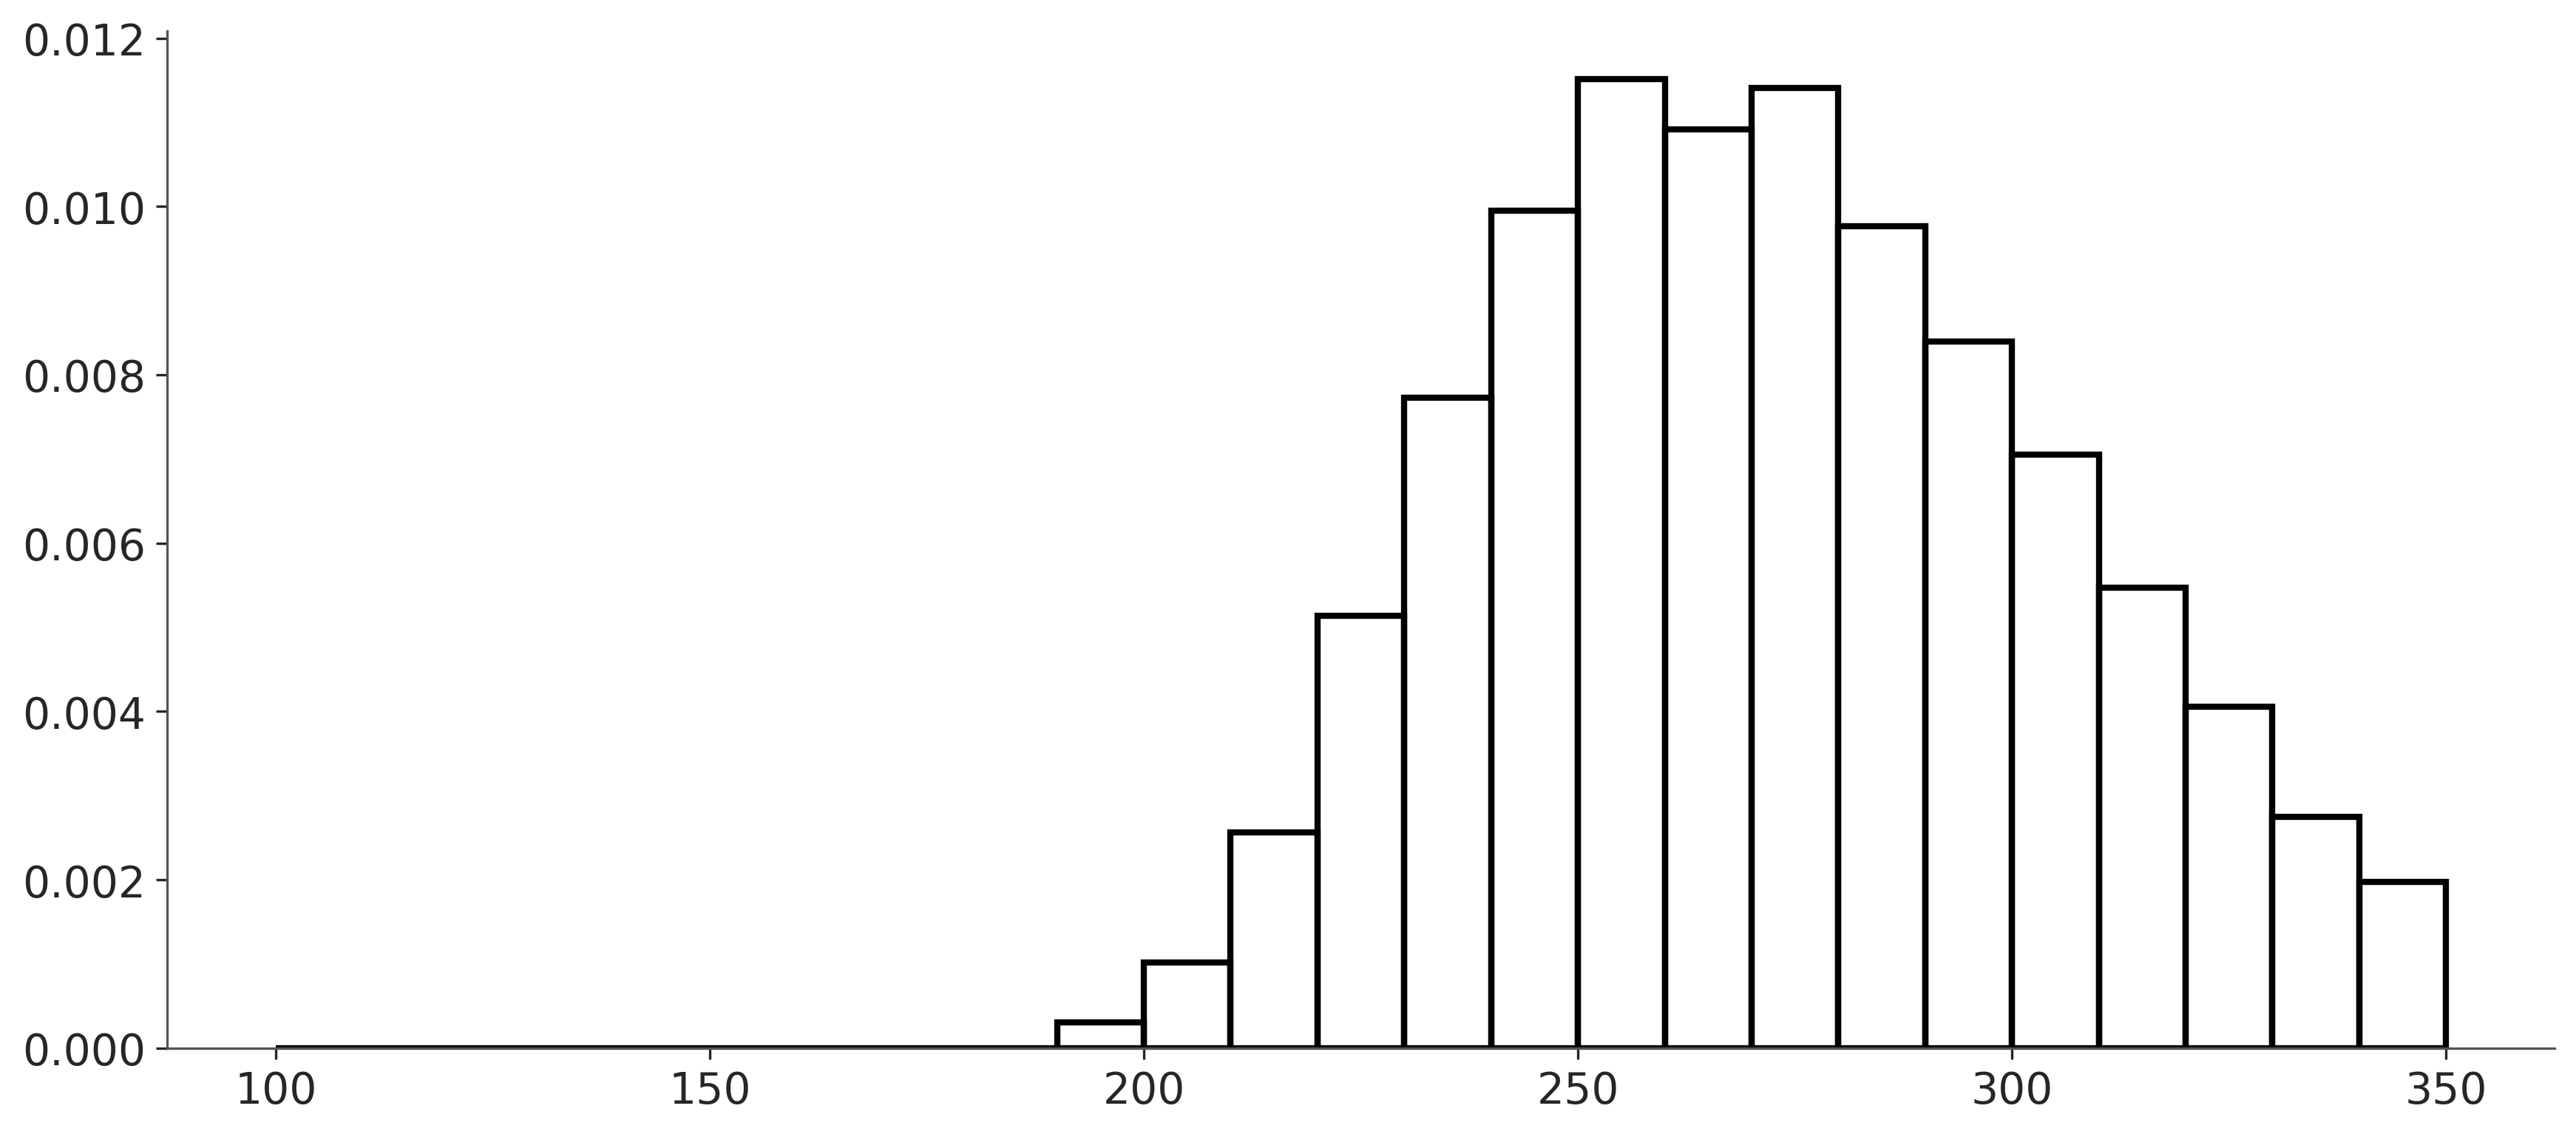

In [24]:
hist_dict = {'bins':np.arange(100,360,10),'density':True,'fill':False,
             'edgecolor':'k','linewidth':2}
pl.hist(db_LensPop_LSST['sig_v'],**hist_dict)
pl.show()

In [16]:
db_LensPop_LSST

zL     zS    tE  sig_v  q_lens_flat  Re_lens  g_lens  r_lens  i_lens  \
0     0.771  3.110  1.26  273.8        0.756     0.74   24.29   21.95   20.51   
1     0.092  1.127  3.60  373.7        0.367     3.55   13.73   12.68   12.30   
2     0.436  1.043  1.55  324.6        0.665     1.33   20.01   18.10   17.27   
3     0.217  1.075  1.62  274.2        0.681     1.58   18.11   16.58   16.04   
4     0.452  2.814  2.21  326.5        0.806     0.98   20.07   18.17   17.28   
...     ...    ...   ...    ...          ...      ...     ...     ...     ...   
8828  0.825  3.071  1.10  262.6        0.879     0.51   24.92   22.32   21.01   
8829  0.330  2.308  0.97  209.6        0.472     0.83   21.08   19.17   18.52   
8830  0.840  1.896  1.43  341.8        0.804     0.96   23.68   21.01   19.73   
8831  0.628  1.220  1.08  307.2        0.597     0.66   22.12   20.21   18.81   
8832  0.294  1.161  1.75  298.6        0.828     0.96   18.79   17.03   16.41   

        xs    ys  q_source_flat  PA_source  Re_source  g_source  r_source  \
0     0.17  0.19          0.689       98.0       0.25     27.22     26.81   
1     1.06 -0.82          0.847       81.3       1.68     22.12     21.83   
2     0.63  0.06          0.805      138.3       0.56     27.21     25.26   
3    -0.88 -0.01          0.890       37.6       0.28     25.23     24.61   
4    -1.22  0.70          0.628      144.3       0.25     25.49     25.50   
...    ...   ...            ...        ...        ...       ...       ...   
8828 -0.29  0.13          0.572       53.3       0.11     26.77     25.98   
8829 -0.00  0.42          0.416       70.4       0.10     27.30     27.35   
8830 -0.16  0.75          0.469      170.8       0.46     25.17     25.29   
8831 -0.68 -0.45          0.223       43.3       0.23     25.78     25.73   
8832 -0.05 -0.77          0.627      124.7       0.48     25.12     24.59   

      i_source   mu_s  g_see  g_see_sub  r_see  r_see_sub  i_see  i_see_sub  \
0        26.81   9.38  1.905      12.41  1.905      19.37  1.905      12.91   
1        21.72   4.20  1.905     100.04  1.905     123.35  1.905     104.58   
2        24.28   4.85  1.905       4.97  1.905      28.66  1.905      45.08   
3        24.10   3.80  1.905      27.40  1.905      42.00  1.905      46.93   
4        25.54   3.08  1.905      22.81  1.905      23.36  1.905      13.84   
...        ...    ...    ...        ...    ...        ...    ...        ...   
8828     26.00   6.93  1.495      17.98  1.495      38.50  1.495      22.89   
8829     27.44  12.28  1.495      20.07  1.495      17.86  1.495      12.65   
8830     25.21   3.75  1.495      29.15  1.495      29.61  1.495      19.23   
8831     25.55   3.54  1.495      18.96  1.495      21.62  1.495      16.66   
8832     24.35   5.32  1.495      34.05  1.495      56.01  1.495      44.88   

        SNR  e1_source  e2_source   PA_lens   e1_lens   e2_lens  
0      0.00  -0.177000  -0.050754  1.310113 -0.120491  0.069207  
1     57.39  -0.079046   0.024772  2.262966 -0.085841 -0.455032  
2      0.00   0.012417  -0.107317  0.000359  0.201201  0.000145  
3     15.43   0.014867   0.056270  0.949806 -0.061280  0.179601  
4     20.99   0.072883  -0.216566  0.461047  0.064898  0.085599  
...     ...        ...        ...       ...       ...       ...  
8828  15.47  -0.077783   0.260917  0.129048  0.062263  0.016436  
8829   0.00  -0.319610   0.260667  0.396096  0.251907  0.255353  
8830  27.69   0.342991  -0.114098  2.577986  0.046629 -0.098132  
8831   0.00   0.037679   0.634205  2.141333 -0.105133 -0.229405  
8832  25.88  -0.080662  -0.214598  1.378630 -0.087228  0.035279  

[8833 rows x 30 columns]

In [10]:
gg_lens_pop.source_number()

11052471

## Generate images of random lenses
The LensingPlots() class has the functionality to draw random lenses and makes an image of it.
Currently

default settings in lenstronomy are chosen for the LSST image settings. These will be able to be replaced with the

LSST simulation tools.

## Generate the full population
We are using the instance of the GalaxyGalaxyLensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [4]:
# specifying cuts of the population
kwargs_lens_cuts = {"mag_arc_limit": {"i": 25}, "min_magnification": 3}
# drawing population
gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

Drawing Lens Systems


100%|██████████| 13559/13559 [02:59<00:00, 75.71it/s] 


In [ ]:
# gg_plot = LensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

# # generate montage indicating which bands are used for the rgb color image
# fig, axes = gg_plot.plot_montage(
#     rgb_band_list=["i", "i", "i"],
#     add_noise=
#False,
#     n_horizont=5,
#     n_vertical=2,
#     kwargs_lens_cut=kwargs_lens_cuts,
# )
# plt.show()

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a GalaxyGalaxyLens() class

object that allows to compute and return these (and more) quantities.

In [30]:
print("Number of lenses:", len(gg_lens_population))

def generate_lens_samples_dict(gg_lens_population_1):
    lens_samples = []
    lens_samples_dict = {'veldisp':[],'mstar':[],'tE':[],'zL':[],'zS':[],'mu_s':[],
                         'defl_e1_light':[], 'defl_e2_light':[], 'defl_e1_mass':[], 'defl_e2_mass':[],'e1_source':[],'e2_source':[],
                         'defl_mass_x':[],'defl_mass_y':[],'defl_gamma':[],'defl_gamma1':[],'defl_gamma2':[],'source_x':[],'source_y':[],
                         'source_Ns':[],'source_Rs':[],'defl_Ns':[],'defl_Rs':[],'defl_light_x':[],'defl_light_y':[],
                         'defl_mag_i_band':[],'source_mag_i_band':[]}
    labels = [
        r"$\sigma_v$",
        r"$\log(M_{*})$",
        r"$\theta_E$",
        r"$z_{\rm l}$",
        r"$z_{\rm s}$",
        r"$m_{\rm source}$",
        r"$m_{\rm lens}$"]
    for gg_lens in tqdm(gg_lens_population_1):
        vel_disp = gg_lens.deflector_velocity_dispersion()
        m_star = gg_lens.deflector_stellar_mass()
        theta_e = gg_lens.einstein_radius
        zl = gg_lens.deflector_redshift
        zs = gg_lens.source_redshift
        #source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)
        #deflector_mag = gg_lens.deflector_magnitude(band="g")
        magnification = gg_lens.extended_source_magnification()
        defl_e1_light, defl_e2_light, defl_e1_mass, defl_e2_mass = gg_lens.deflector_ellipticity()
        source_e1,source_e2 = gg_lens.source.ellipticity
        defl_gamma1 = gg_lens.deflector_mass_model_lenstronomy()[1][1]['gamma1']
        defl_gamma2 = gg_lens.deflector_mass_model_lenstronomy()[1][1]['gamma2']
        defl_mass_x = gg_lens.deflector_mass_model_lenstronomy()[1][0]['center_x']
        defl_mass_y = gg_lens.deflector_mass_model_lenstronomy()[1][0]['center_y']
        defl_light_x = gg_lens.deflector_light_model_lenstronomy()[1][0]['center_x']
        defl_light_y = gg_lens.deflector_light_model_lenstronomy()[1][0]['center_y']
        defl_Rs = gg_lens.deflector_light_model_lenstronomy()[1][0]['R_sersic']
        defl_Ns = gg_lens.deflector_light_model_lenstronomy()[1][0]['n_sersic']
        source_x,source_y = gg_lens.source_position
        source_Rs = gg_lens.source_light_model_lenstronomy()[1]['kwargs_source'][0]['R_sersic']
        source_Ns = gg_lens.source_light_model_lenstronomy()[1]['kwargs_source'][0]['n_sersic']
        defl_mag_i_band = gg_lens.deflector_magnitude('i')
        source_mag_i_band = gg_lens.extended_source_magnitude('i')
        lens_samples_dict['veldisp'].append(vel_disp)
        lens_samples_dict['mstar'].append(np.log10(m_star))
        lens_samples_dict['tE'].append(theta_e)
        lens_samples_dict['zL'].append(zl)
        lens_samples_dict['zS'].append(zs)
        lens_samples_dict['mu_s'].append(magnification)
        lens_samples_dict['defl_e1_light'].append(defl_e1_light)
        lens_samples_dict['defl_e2_light'].append(defl_e2_light)
        lens_samples_dict['defl_e1_mass'].append(defl_e1_mass)
        lens_samples_dict['defl_e2_mass'].append(defl_e2_mass)
        lens_samples_dict['e1_source'].append(source_e1)
        lens_samples_dict['e2_source'].append(source_e2)
        lens_samples_dict['defl_gamma'].append(2) #Hardcoded in slsim.lens.Lens.deflector_mass_model_lenstronomy
        lens_samples_dict['defl_gamma1'].append(defl_gamma1) 
        lens_samples_dict['defl_gamma2'].append(defl_gamma2) 
        lens_samples_dict['defl_mass_x'].append(defl_mass_x) 
        lens_samples_dict['defl_mass_y'].append(defl_mass_y) 
        lens_samples_dict['defl_light_x'].append(defl_light_x) 
        lens_samples_dict['defl_light_y'].append(defl_light_y) 
        lens_samples_dict['source_x'].append(source_x) 
        lens_samples_dict['source_y'].append(source_y) 
        lens_samples_dict['source_Rs'].append(source_Rs)
        lens_samples_dict['source_Ns'].append(source_Ns)
        lens_samples_dict['defl_Rs'].append(defl_Rs)
        lens_samples_dict['defl_Ns'].append(defl_Ns)
        lens_samples_dict['defl_mag_i_band'].append(defl_mag_i_band)
        lens_samples_dict['source_mag_i_band'].append(source_mag_i_band)
    return lens_samples_dict

lens_samples_dict = generate_lens_samples_dict(gg_lens_population)
lens_samples_dict_no_cut = generate_lens_samples_dict(SLSim_lenspop_nocut)


Number of lenses: 142


100%|██████████| 1376/1376 [01:03<00:00, 21.77it/s]


In [35]:
#Saving the catalogue so cutouts of individual systems can be generated within 'Code to Generate Paltas Configs.ipynb':
def generate_simpipeline_db(lens_samples_dict_0,filename=None):
    simpipeline_db = pd.DataFrame(lens_samples_dict_0)
    simpipeline_db = simpipeline_db.rename({'source_x':'xs','source_y':'ys','source_Rs':'Re_source','defl_Rs':'Re_lens',
                                          'source_mag_i_band':'i_source','defl_mag_i_band':'i_lens',
                                          'source_Ns':'Ns'},axis=1)
    if filename is not None:
        simpipeline_db.to_csv(f'/mnt/zfsusers/hollowayp/sim-pipeline/notebooks/{filename}')
    #simpipeline_db.to_csv('/mnt/extraspace/hollowayp/paltas_data/Example_SL_12/test/simpipeline_catalogue_db.csv')
    return simpipeline_db

simpipeline_db_no_cuts = generate_simpipeline_db(lens_samples_dict_no_cut)


# Comparison with Fundamental Plane 
Taken from Bezanson 2015, https://ui.adsabs.harvard.edu/abs/2015ApJ...799..148B/abstract

In [192]:
# #!python3 -m pip install arviz
# data = az.load_arviz_data("non_centered_eight")
# fig,ax = pl.subplots(2,2,figsize=(3,3))
# az.plot_pair(
#     {'x':np.random.normal(size=100000),'y':np.random.random(size=100000)},
#     var_names=['x','y'],
#     kind='kde',
#     marginals=True,
#     ax=ax,
#     marginal_kwargs={'plot_kwargs':{'linewidth':1}},
#     textsize=10)
# pl.show()

In [22]:
db_LensPop_LSST.columns

Index(['zL', 'zS', 'tE', 'sig_v', 'q_lens_flat', 'Re_lens', 'g_lens', 'r_lens',
       'i_lens', 'xs', 'ys', 'q_source_flat', 'PA_source', 'Re_source',
       'g_source', 'r_source', 'i_source', 'mu_s', 'g_see', 'g_see_sub',
       'r_see', 'r_see_sub', 'i_see', 'i_see_sub', 'SNR', 'e1_source',
       'e2_source', 'PA_lens', 'e1_lens', 'e2_lens', 'defl_mass_x',
       'defl_mass_y', 'defl_light_x', 'defl_light_y', 'defl_gamma',
       'defl_e1_mass', 'defl_e2_mass', 'defl_e1_light', 'defl_e2_light',
       'defl_gamma1', 'defl_gamma2', 'defl_Ns', 'source_Ns'],
      dtype='object')

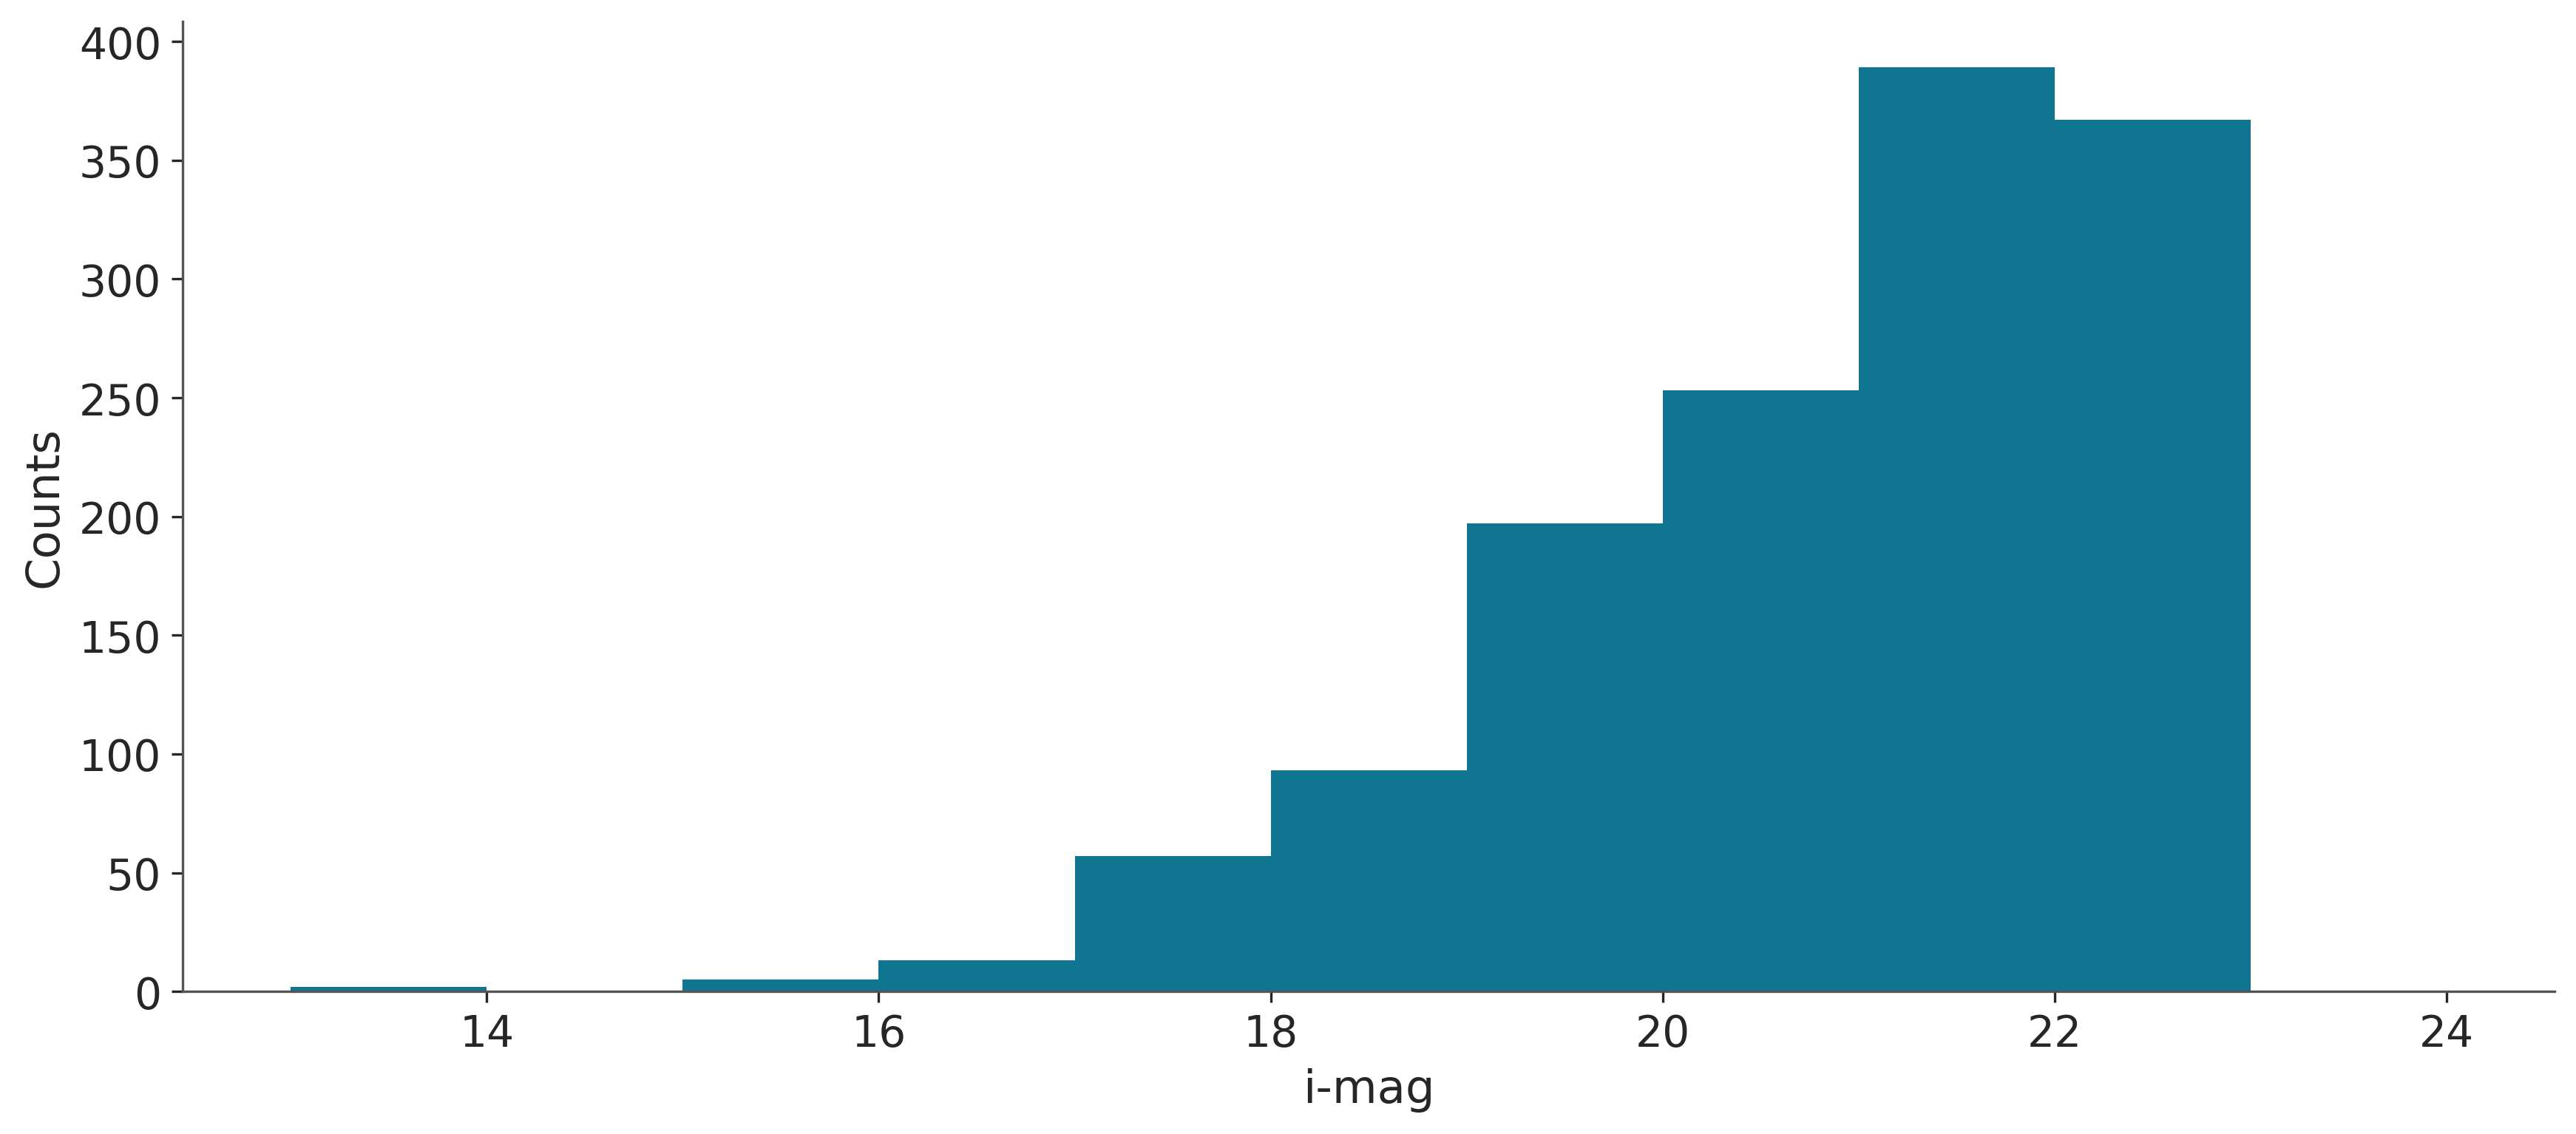

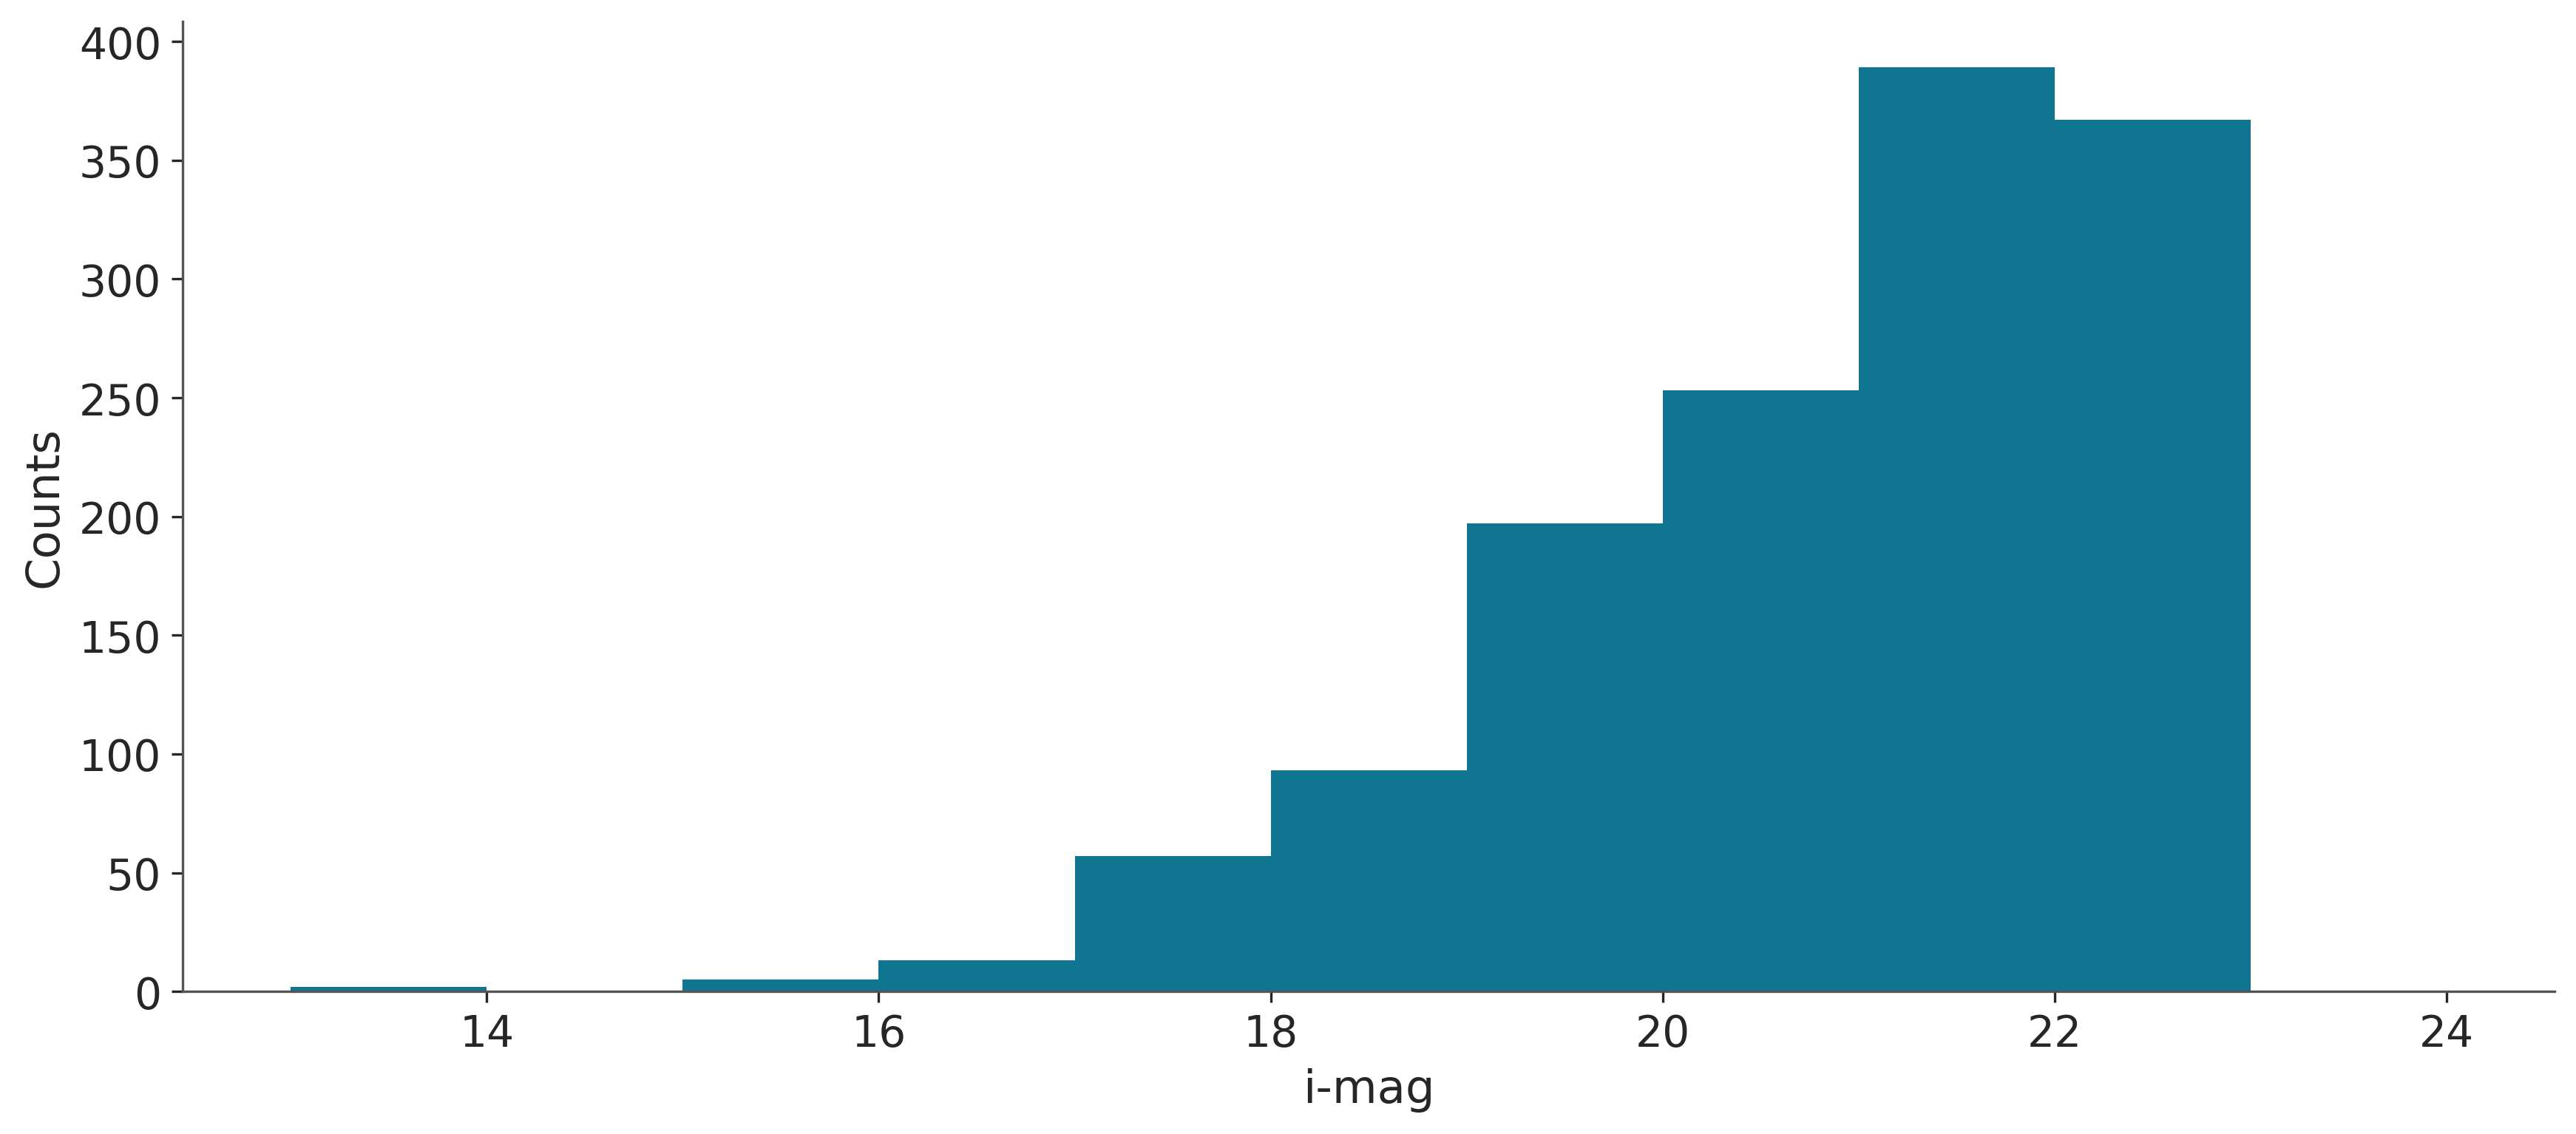

In [62]:
pl.hist(simpipeline_db_no_cuts['i_lens'],bins=np.arange(13,25,1))
pl.ylabel('Counts',fontsize=15)
pl.xlabel('i-mag',fontsize=15)
pl.show()

/tmp/ipykernel_47007/139847370.py:65: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
/tmp/ipykernel_47007/139847370.py:65: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


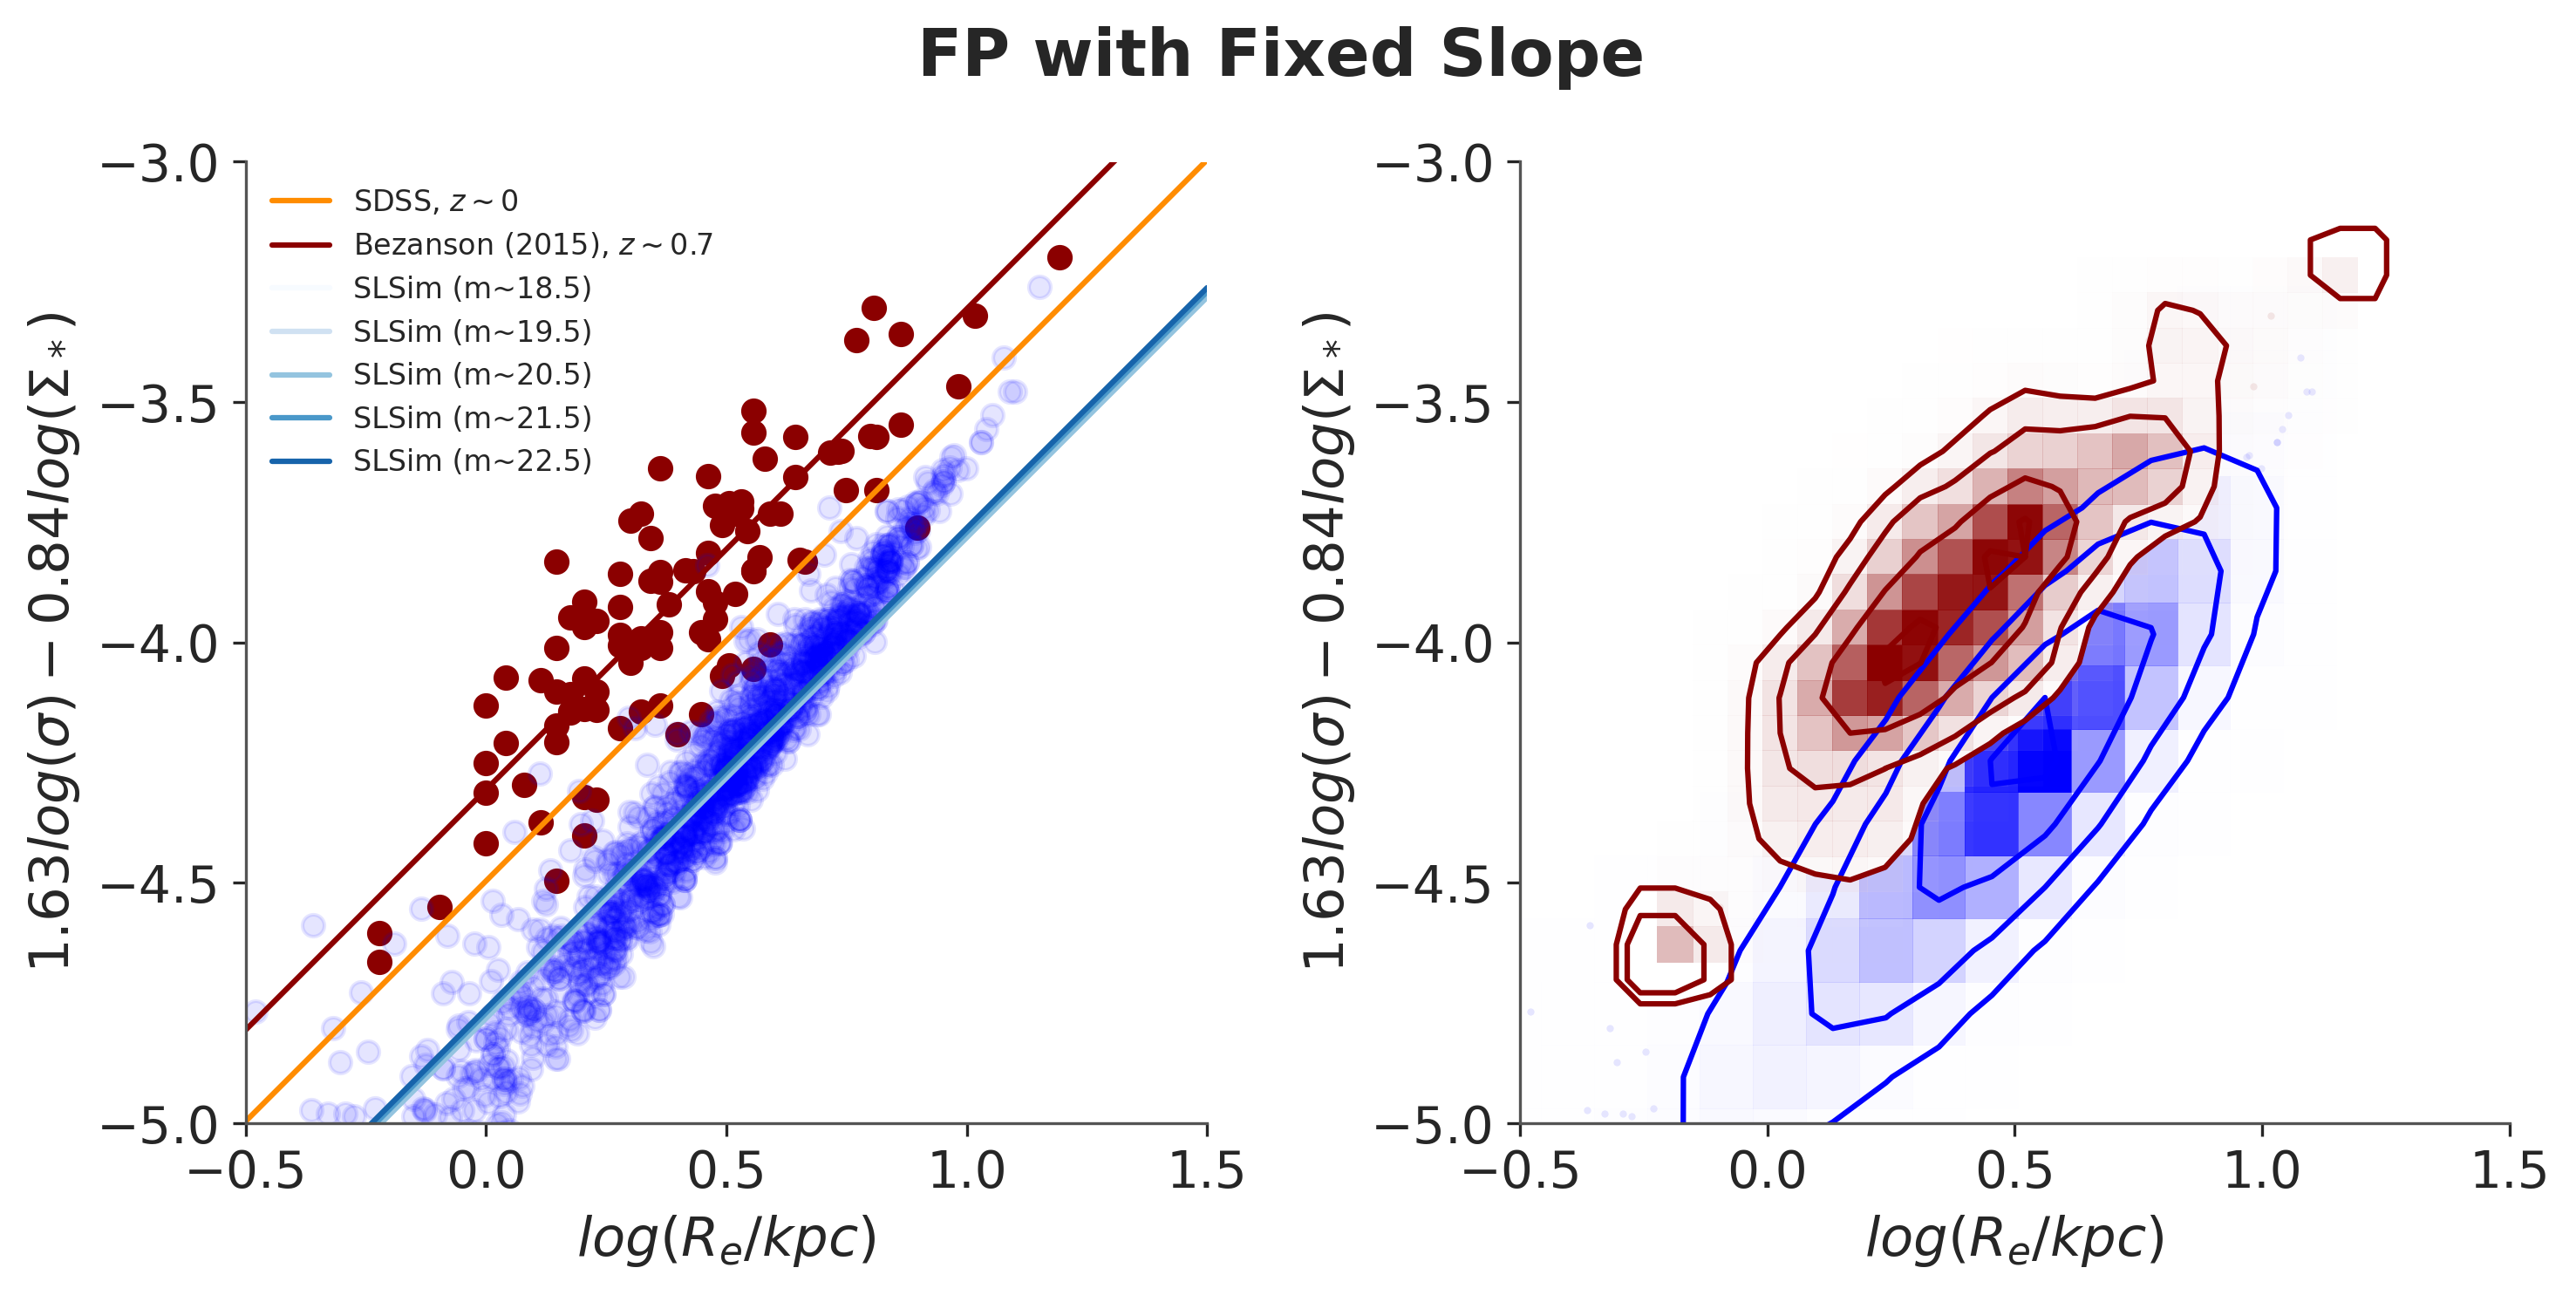

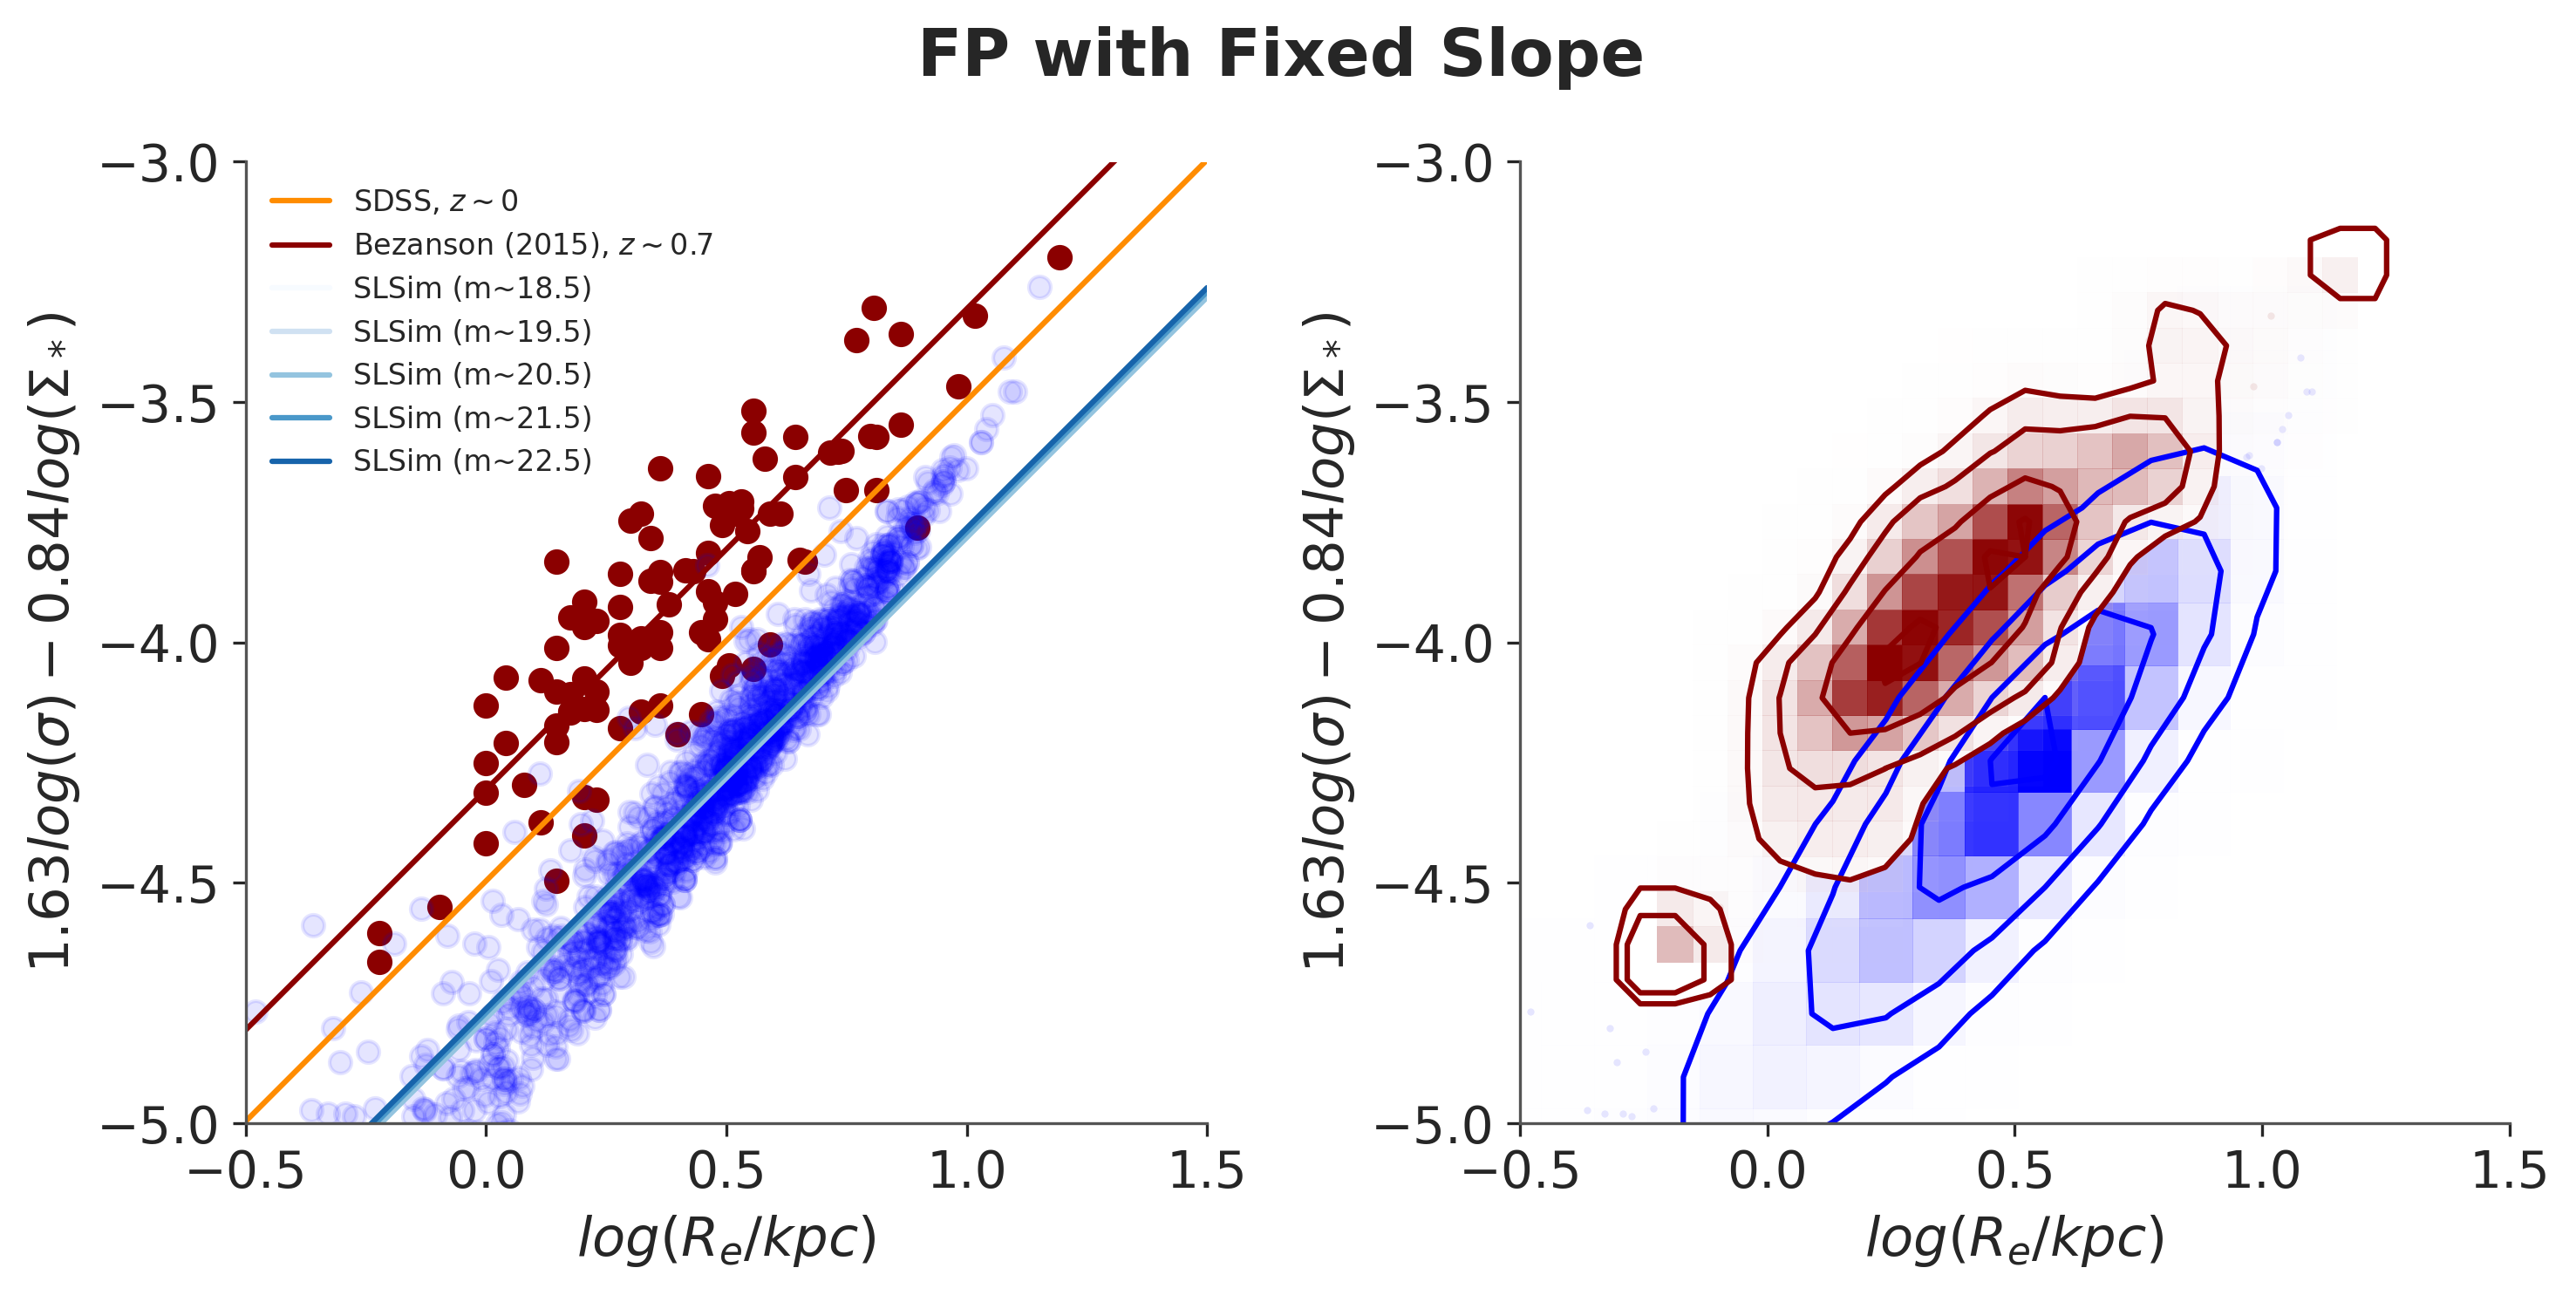

In [69]:
def y(x,m,c):
    return m*x+c

def y_intercept_only(x,c):
    return x+c

simpipeline_db_no_cuts['D_A_kpc'] = cosmo.angular_diameter_distance(np.array(simpipeline_db['zL'])).to(U.kpc).value
simpipeline_db_no_cuts['Re_lens_kpc'] = simpipeline_db_no_cuts['Re_lens']*(np.pi/180)*(1/3600)*simpipeline_db_no_cuts['D_A_kpc']

X_plot_FP = np.linspace(-0.5,1.5,100)
Y_plot_SDSS_FP = X_plot_FP-4.496
Y_plot_DEIMOS_FP = X_plot_FP-4.306

X_plot_bz_2015 = np.log10(bz_2015['Re'])
Y_plot_bz_2015 = 1.63*np.log10(bz_2015['sig.A'])-0.84*np.log10(10**bz_2015['logM']/(2*np.pi*bz_2015['Re']**2))

fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].plot(X_plot_FP,Y_plot_SDSS_FP,c='darkorange',label='SDSS, $z\sim0$')
ax[0].plot(X_plot_FP,Y_plot_DEIMOS_FP,c='darkred',label='Bezanson (2015), $z\sim0.7$')
ax[0].scatter(X_plot_bz_2015,Y_plot_bz_2015,c='darkred',label='_nolegend_')

SLSim_X_all = np.log10(simpipeline_db_no_cuts['Re_lens_kpc'])
SLSim_Y_all = 1.63*np.log10(simpipeline_db_no_cuts['veldisp'])-0.84*np.log10(10**simpipeline_db_no_cuts['mstar']/(2*np.pi*simpipeline_db_no_cuts['Re_lens_kpc']**2))
ax[0].scatter(SLSim_X_all,SLSim_Y_all,c='blue',label='_nolegend_',alpha=0.1)
c_SLSim_all,_= curve_fit(y_intercept_only,SLSim_X_all,SLSim_Y_all)
#ax[0].plot(X_plot_FP,y_intercept_only(X_plot_FP,c_SLSim_all),c='blue',label='SLSim Systems (all)')

dB = 0.2;dM = 1
z_bins = np.arange(0,1.2+dB,dB)
mag_bins = np.arange(18,23+dM,dM)
#for ii,redshift_bin in enumerate(z_bins):
for ii,mag_bin in enumerate(mag_bins):
#    c_i = pl.cm.Blues(np.linspace(0,1,len(z_bins)))[ii]
    c_i = pl.cm.Blues(np.linspace(0,1,len(mag_bins)))[ii]
    indx = np.where((mag_bin<simpipeline_db_no_cuts.i_lens)&\
                             (simpipeline_db_no_cuts.i_lens<mag_bin+dM))[0]
    if len(indx)==0: continue
#    indx = np.where((redshift_bin<simpipeline_db_no_cuts.zL)&\
#                             (simpipeline_db_no_cuts.zL<redshift_bin+dB))[0]
    SLSim_X = np.log10(simpipeline_db_no_cuts['Re_lens_kpc'][indx])
    SLSim_Y = (1.63*np.log10(simpipeline_db_no_cuts['veldisp'])-\
               0.84*np.log10(10**simpipeline_db_no_cuts['mstar']/\
              (2*np.pi*simpipeline_db_no_cuts['Re_lens_kpc']**2)))[indx]
    c_SLSim,_= curve_fit(y_intercept_only,SLSim_X,SLSim_Y)
    ax[0].plot(X_plot_FP,y_intercept_only(X_plot_FP,c_SLSim),c=c_i,
#               label=f'SLSim (z~{np.round(redshift_bin+dB/2,2)})')
               label=f'SLSim (m~{np.round(mag_bin+dM/2,2)})')

ax[0].axis('square') 
X_lim = (-0.5,1.5)
Y_lim=(-5,-3)
ax[0].legend(fontsize=8)
corner.hist2d(SLSim_X_all.to_numpy(),SLSim_Y_all.to_numpy(),ax=ax[1],color='blue',smooth=1)
corner.hist2d(X_plot_bz_2015.to_numpy(),Y_plot_bz_2015.to_numpy(),ax=ax[1],color='darkred',smooth=1)

for i in range(2):
    ax[i].set_xlim(X_lim)
    ax[i].set_ylim(Y_lim)
    ax[i].set_xlabel('$log(R_{e}/kpc)$',fontsize=15)
    ax[i].set_ylabel('$1.63 log(\sigma)-0.84 log(\Sigma_*)$',fontsize=15)
    ax[i].set_xticks(np.arange(X_lim[0],X_lim[-1]+0.5,0.5))
    ax[i].set_yticks(np.arange(Y_lim[0],Y_lim[-1]+0.5,0.5))

pl.suptitle('FP with Fixed Slope')
pl.tight_layout()

pl.show()

/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


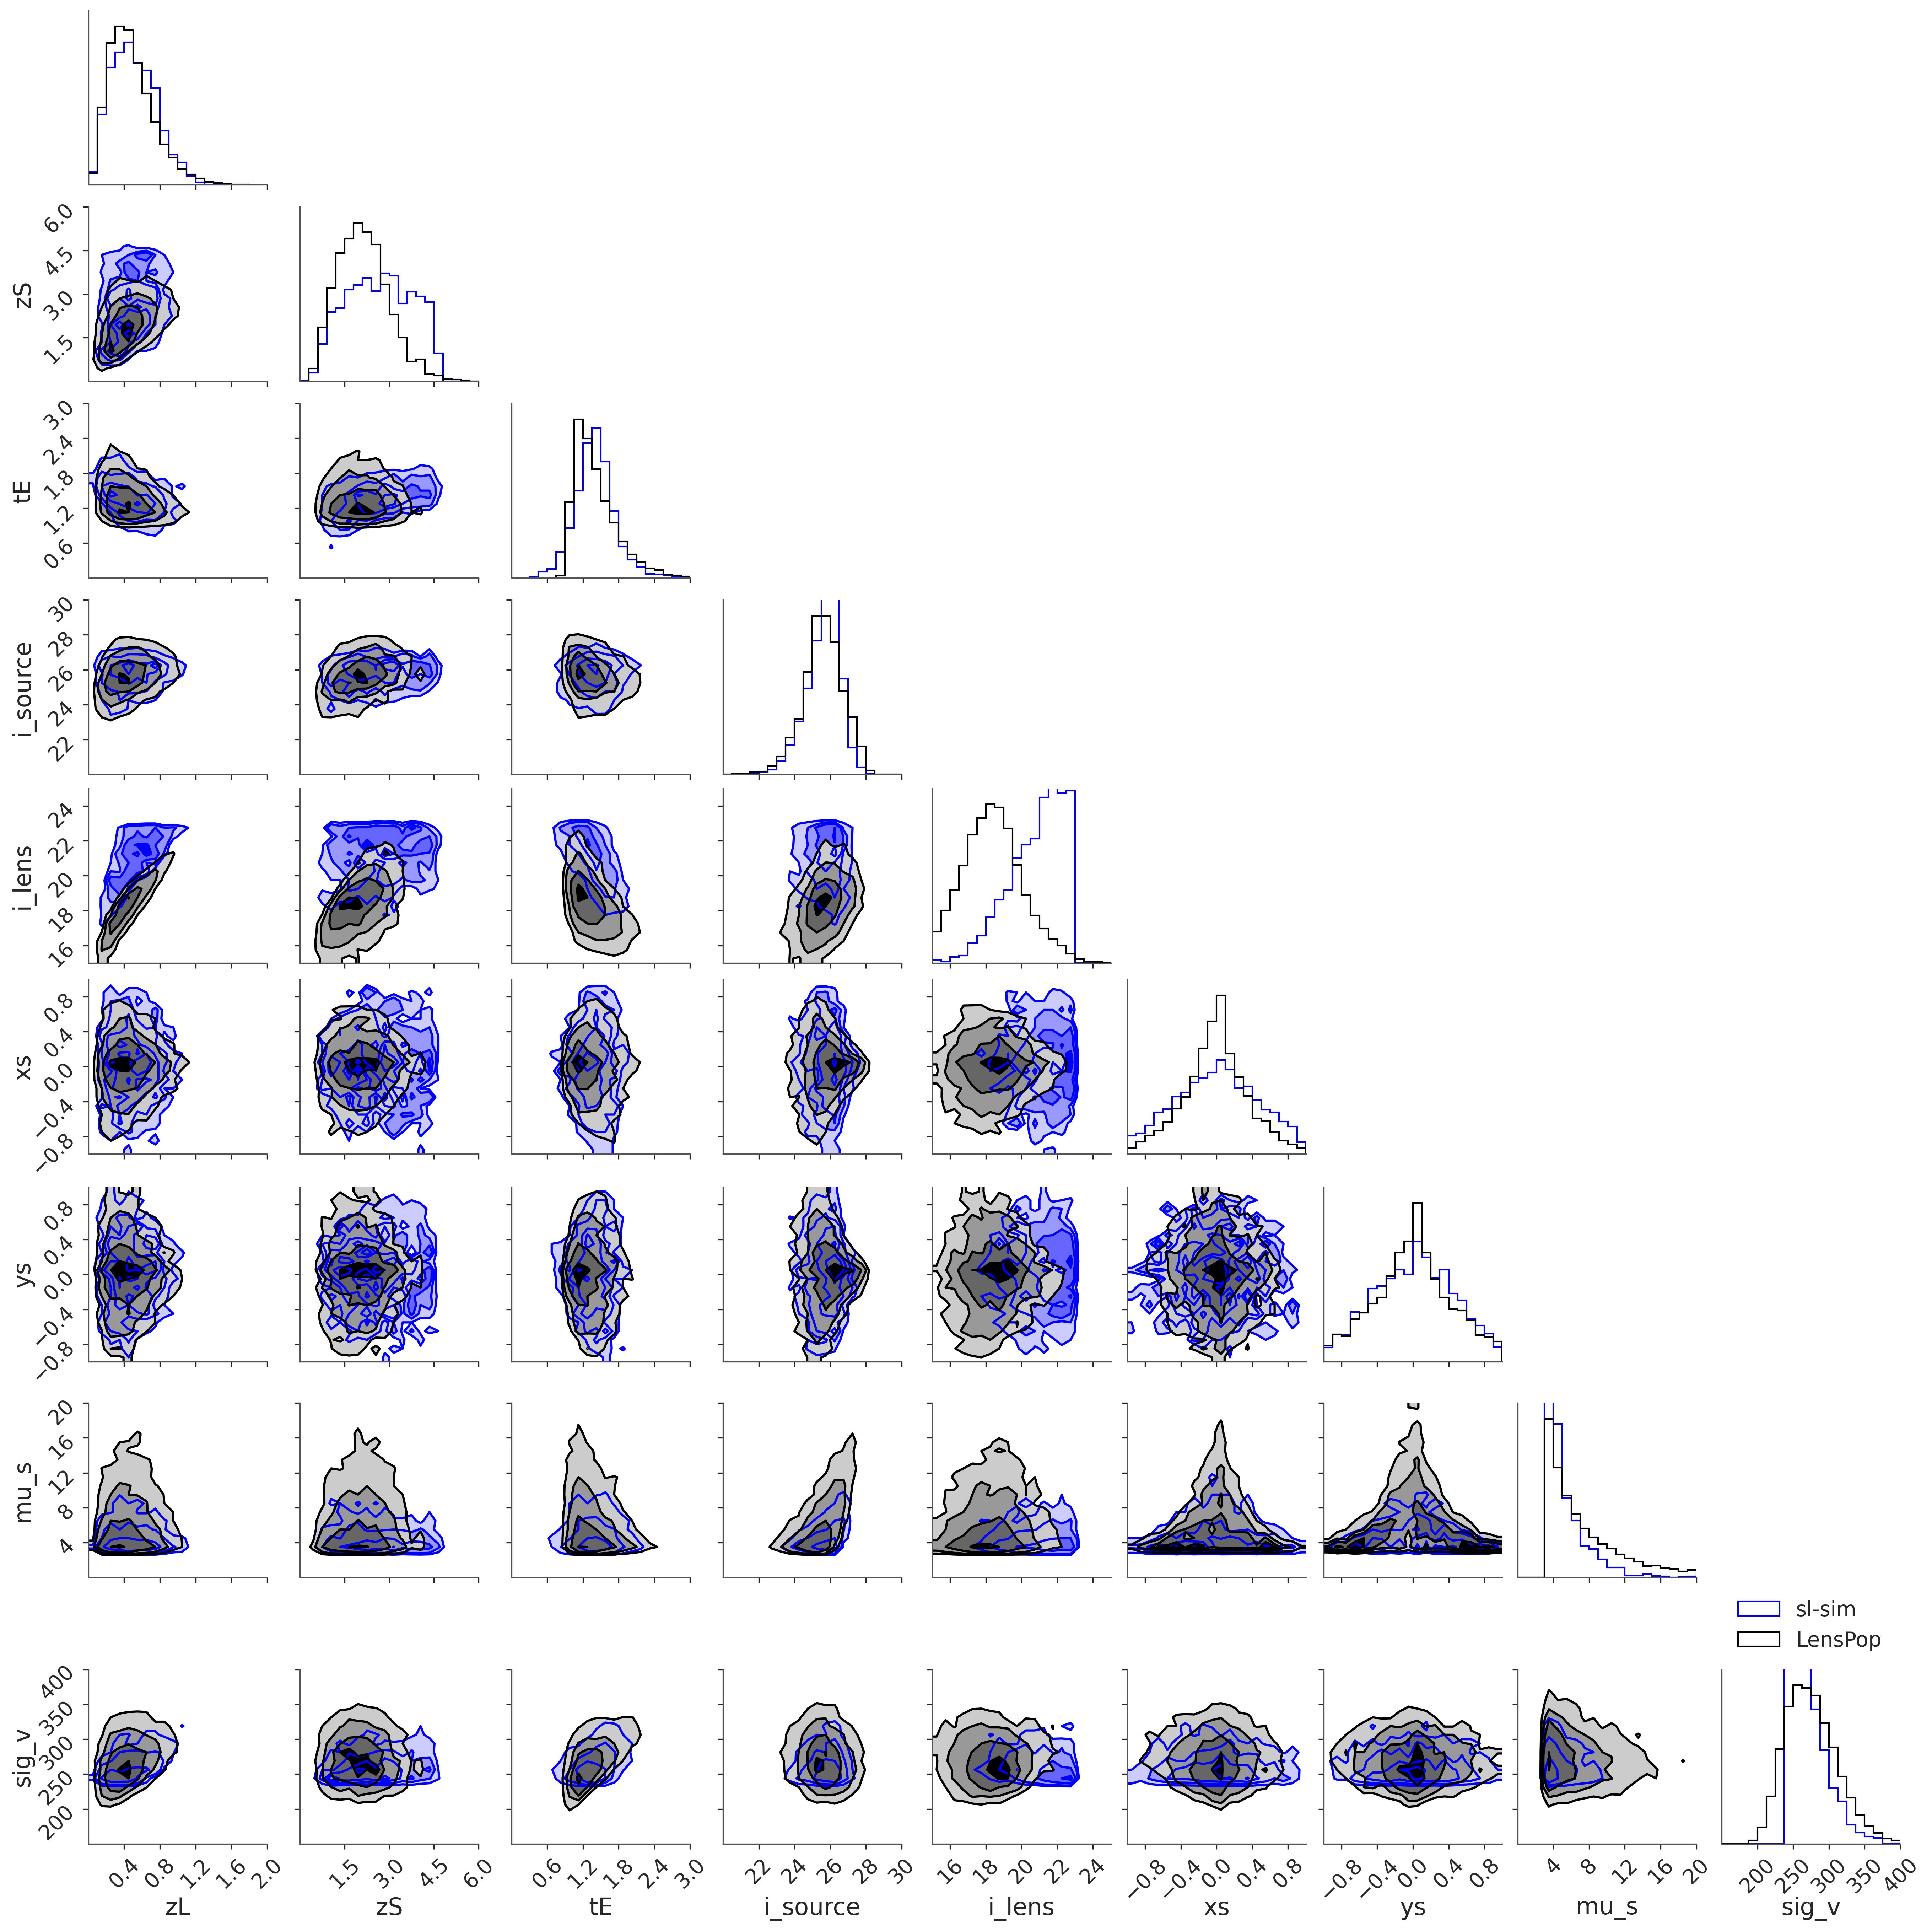

In [9]:
#Comparing the Sim-pipeline lens population to LensPop:
def hist2d_kwargs_func(color):
    return {
        "plot_density": False,
        "plot_contours": True,
        "fill_contours":True,
        "plot_datapoints": False,
        "data_kwargs": {"ms": 5},
        "color":color,
        "alpha":0.2,
        #Changing scatter point size:
        "data_kwargs":{'ms':2},
        "labels":LensPop_property_list,
        "bins":20,
        "fontsize":25
    }
def hist_kwargs_func(edgecolor):
    return {
        'density':True,
        'fill':False,
        'edgecolor':edgecolor}

LensPop_property_list = ['zL','zS','tE','i_source'         ,'i_lens','xs','ys','mu_s','sig_v']
SimPip_property_list =  ['zL','zS','tE','source_mag_i_band','defl_mag_i_band','source_x','source_y','mu_s','veldisp'] #MUST be in the same order as LensPop_property_list
paltas_property_list = ['main_deflector*parameters*z_lens','source*parameters*z_source','main_deflector*parameters*theta_E',
                        'source*parameters*mag_app','lens_light*parameters*mag_app',
                        'source*parameters*center_x','source*parameters*center_y']
paltas_gen_property_list = [elem.replace("*","_") for elem in paltas_property_list]

fig = pl.figure(figsize=(2*len(LensPop_property_list),2*len(LensPop_property_list)))
range_list = [(0,2),(0,6),(0,3),(20,30),(15,25),(-1,1),(-1,1),(0,20),(150,400)]
corner.corner(np.array([lens_samples_dict[elem] for elem in SimPip_property_list]).T, **hist2d_kwargs_func('blue'),fig=fig,
              hist_kwargs=hist_kwargs_func('blue'),range=range_list)
corner.corner(np.array([db_LensPop_LSST[elem] for elem in LensPop_property_list]).T, **hist2d_kwargs_func('k'),fig=fig,
              hist_kwargs=hist_kwargs_func('k'),range=range_list)
#Plot random sample from the paltas distribution (ignoring any covariances)
# corner.corner(np.array([norm(sim_pipeline_db.loc[sim_pipeline_db['prop']==elem]['mean'],
#                              sim_pipeline_db.loc[sim_pipeline_db['prop']==elem]['std']).rvs(1000)
#                              for elem in paltas_property_list]).T, **hist2d_kwargs_func('orange'),fig=fig,
#               hist_kwargs=hist_kwargs_func('orange'),range=range_list)
#Plot random sample from the generated paltas distribution (including any covariances)
paltas_db = pd.read_csv('/mnt/extraspace/hollowayp/paltas_data/Example_SL_10/validation/1/metadata.csv')
#corner.corner(np.array([paltas_db[elem] for elem in paltas_gen_property_list]).T, **hist2d_kwargs_func('orange'),fig=fig,
#               hist_kwargs=hist_kwargs_func('orange'),range=range_list)


#fig.legend(['sl-sim','LensPop'],bbox_to_anchor=(0., 1.0, 0.3, .0))#, loc=4)
#Or 
pl.legend(['sl-sim','LensPop','Paltas'], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

for ax in fig.get_axes():
    xlabel_i = ax.get_xlabel()
    ylabel_i = ax.get_ylabel()
    ax.set_xlabel(xlabel_i, fontsize=16)
    ax.set_ylabel(ylabel_i, fontsize=16)

pl.show()

# Sim-pipeline Population Properties

In [14]:
db_to_config_format_dict = {'zL':['main_deflector*parameters*z_lens','lens_light*parameters*z_source'], #Lens **light** redshift as well
                            'tE':'main_deflector*parameters*theta_E',
                            'defl_mass_x':'main_deflector*parameters*center_x',
                            'defl_mass_y':'main_deflector*parameters*center_y',
                            'defl_gamma':'main_deflector*parameters*gamma',
                            'defl_e1_mass':'main_deflector*parameters*e1',
                            'defl_e2_mass':'main_deflector*parameters*e2',
                            'defl_gamma1':'main_deflector*parameters*gamma1',
                            'defl_gamma2':'main_deflector*parameters*gamma2',
                            'defl_mag_i_band':'lens_light*parameters*mag_app',
                            'defl_Rs':'lens_light*parameters*R_sersic',
                            'defl_Ns':'lens_light*parameters*n_sersic',
                            'defl_e1_light':'lens_light*parameters*e1',
                            'defl_e2_light':'lens_light*parameters*e2',
                            'defl_light_x':'lens_light*parameters*center_x',
                            'defl_light_y':'lens_light*parameters*center_y',
                            'zS':'source*parameters*z_source',
                            'source_mag_i_band':'source*parameters*mag_app',
                            'source_Rs':'source*parameters*R_sersic',
                            'source_Ns':'source*parameters*n_sersic',
                            'source_x':'source*parameters*center_x',
                            'source_y':'source*parameters*center_y',
                            'e1_source':'source*parameters*e1',
                            'e2_source':'source*parameters*e2'}

db_to_config_trunc_dict = {'zL':[True,True],
                            'tE':True,
                            'defl_mass_x':False,
                            'defl_mass_y':False,
                            'defl_gamma':True,
                            'defl_e1_mass':False,
                            'defl_e2_mass':False,
                            'defl_gamma1':False,
                            'defl_gamma2':False,
                            'defl_mag_i_band':False,
                            'defl_Rs':True,
                            'defl_Ns':True,
                            'defl_e1_light':False,
                            'defl_e2_light':False,
                            'defl_light_x':False,
                            'defl_light_y':False,
                            'zS':True,
                            'source_mag_i_band':False,
                            'source_Rs':True,
                            'source_Ns':True,
                            'source_x':False,
                            'source_y':False,
                            'e1_source':False,
                            'e2_source':False}
list_of_properties=[]
list_of_means=[]
list_of_std=[]
list_of_sigma_to_zero=[]
list_of_trunc_bool=[]
for prop_i in tqdm(db_to_config_format_dict.keys()):
    if isinstance(db_to_config_format_dict[prop_i],list):
        list_of_properties.extend(db_to_config_format_dict[prop_i])
        list_of_trunc_bool.extend(db_to_config_trunc_dict[prop_i])
        N_add=2
    else:
        list_of_properties.append(db_to_config_format_dict[prop_i])
        list_of_trunc_bool.append(db_to_config_trunc_dict[prop_i])
        N_add=1
    for i in range(N_add):
        mean_i = np.mean(lens_samples_dict[prop_i])
        std_i = np.std(lens_samples_dict[prop_i])
        list_of_means.append(mean_i)
        list_of_std.append(std_i)
        list_of_sigma_to_zero.append(-mean_i/std_i)

sim_pipeline_db = pd.DataFrame({'prop':list_of_properties,
                                'mean':list_of_means,
                                'std':list_of_std,
                                'sigma_to_zero':list_of_sigma_to_zero,
                                'trunc_bool':list_of_trunc_bool,
                                'std1p2':1.2*np.array(list_of_std),
                                'sigma1p2_to_zero':np.array(list_of_means)/(1.2*np.array(list_of_std))
                                })

sim_pipeline_db

  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_31243/787897702.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  list_of_sigma_to_zero.append(-mean_i/std_i)
100%|██████████| 24/24 [00:00<00:00, 2915.16it/s]
/tmp/ipykernel_31243/787897702.py:77: RuntimeWarning: divide by zero encountered in divide
  'sigma1p2_to_zero':np.array(list_of_means)/(1.2*np.array(list_of_std))


prop       mean       std  sigma_to_zero  \
0     main_deflector*parameters*z_lens   0.513357  0.244464      -2.099933   
1       lens_light*parameters*z_source   0.513357  0.244464      -2.099933   
2    main_deflector*parameters*theta_E   1.403717  0.333186      -4.213011   
3   main_deflector*parameters*center_x   0.003990  0.094945      -0.042020   
4   main_deflector*parameters*center_y  -0.002219  0.100433       0.022092   
5      main_deflector*parameters*gamma   2.000000  0.000000           -inf   
6         main_deflector*parameters*e1  -0.005190  0.108125       0.047998   
7         main_deflector*parameters*e2   0.062109  0.092048      -0.674746   
8     main_deflector*parameters*gamma1  -0.001090  0.066144       0.016475   
9     main_deflector*parameters*gamma2  -0.001196  0.068715       0.017412   
10       lens_light*parameters*mag_app  20.815668  1.578260     -13.189001   
11      lens_light*parameters*R_sersic   0.440946  0.440441      -1.001145   
12      lens_light*parameters*n_sersic   4.000000  0.000000           -inf   
13            lens_light*parameters*e1  -0.006897  0.089796       0.076808   
14            lens_light*parameters*e2   0.065640  0.064406      -1.019155   
15      lens_light*parameters*center_x   0.003990  0.094945      -0.042020   
16      lens_light*parameters*center_y  -0.002219  0.100433       0.022092   
17          source*parameters*z_source   2.681238  1.078394      -2.486324   
18           source*parameters*mag_app  25.645591  0.928048     -27.633909   
19          source*parameters*R_sersic   0.517638  0.283629      -1.825054   
20          source*parameters*n_sersic   1.000000  0.000000           -inf   
21          source*parameters*center_x   0.015916  0.528113      -0.030138   
22          source*parameters*center_y   0.003500  0.504906      -0.006933   
23                source*parameters*e1  -0.002980  0.208161       0.014318   
24                source*parameters*e2  -0.008969  0.209997       0.042709   

    trunc_bool    std1p2  sigma1p2_to_zero  
0         True  0.293356          1.749944  
1         True  0.293356          1.749944  
2         True  0.399823          3.510842  
3        False  0.113934          0.035017  
4        False  0.120520         -0.018410  
5         True  0.000000               inf  
6        False  0.129750         -0.039998  
7        False  0.110458          0.562288  
8        False  0.079373         -0.013729  
9        False  0.082458         -0.014510  
10       False  1.893912         10.990834  
11        True  0.528530          0.834288  
12        True  0.000000               inf  
13       False  0.107756         -0.064007  
14       False  0.077287          0.849296  
15       False  0.113934          0.035017  
16       False  0.120520         -0.018410  
17        True  1.294073          2.071937  
18       False  1.113657         23.028257  
19        True  0.340355          1.520878  
20        True  0.000000               inf  
21       False  0.633735          0.025115  
22       False  0.605888          0.005777  
23       False  0.249794         -0.011931  
24       False  0.251996         -0.035591

In [103]:
#from IPython.display import display,Pretty
#display(Pretty(glob.glob("/mnt/extraspace/hollowayp/paltas_data/Example_SL_4/*/*/config*.py")[0]))

In [15]:
from Load_LensPop_LSST_db import db_LensPop_LSST as db_LSST_orig
db_LSST_orig.columns

Index(['zL', 'zS', 'tE', 'sig_v', 'q_lens_flat', 'Re_lens', 'g_lens', 'r_lens',
       'i_lens', 'xs', 'ys', 'q_source_flat', 'PA_source', 'Re_source',
       'g_source', 'r_source', 'i_source', 'mu_s', 'g_see', 'g_see_sub',
       'r_see', 'r_see_sub', 'i_see', 'i_see_sub', 'SNR', 'e1_source',
       'e2_source', 'PA_lens', 'e1_lens', 'e2_lens'],
      dtype='object')

# Now for LensPop

In [16]:
Lenspop_db_to_config_format_dict = {'zL':['main_deflector*parameters*z_lens','lens_light*parameters*z_source'],
                            'tE':'main_deflector*parameters*theta_E',
                            'defl_mass_x':'main_deflector*parameters*center_x',#
                            'defl_mass_y':'main_deflector*parameters*center_y',#
                            'defl_gamma':'main_deflector*parameters*gamma',#
                            'defl_e1_mass':'main_deflector*parameters*e1',#
                            'defl_e2_mass':'main_deflector*parameters*e2',#
                            'defl_gamma1':'main_deflector*parameters*gamma1',#
                            'defl_gamma2':'main_deflector*parameters*gamma2',#
                            'i_lens':'lens_light*parameters*mag_app',
                            'Re_lens':'lens_light*parameters*R_sersic',
                            'defl_Ns':'lens_light*parameters*n_sersic',#
                            'defl_e1_light':'lens_light*parameters*e1',#
                            'defl_e2_light':'lens_light*parameters*e2',#
                            'defl_light_x':'lens_light*parameters*center_x',#
                            'defl_light_y':'lens_light*parameters*center_y',#
                            'zS':'source*parameters*z_source',
                            'i_source':'source*parameters*mag_app',
                            'Re_source':'source*parameters*R_sersic',
                            'source_Ns':'source*parameters*n_sersic',#
                            'xs':'source*parameters*center_x',
                            'ys':'source*parameters*center_y',
                            'e1_source':'source*parameters*e1',
                            'e2_source':'source*parameters*e2'}

Lenspop_to_config_trunc_dict = {'zL':[True,True],
                            'tE':True,
                            'defl_mass_x':False,
                            'defl_mass_y':False,
                            'defl_gamma':True,
                            'defl_e1_mass':False,
                            'defl_e2_mass':False,
                            'defl_gamma1':False,
                            'defl_gamma2':False,
                            'i_lens':False,
                            'Re_lens':True,
                            'defl_Ns':True,
                            'defl_e1_light':False,
                            'defl_e2_light':False,
                            'defl_light_x':False,
                            'defl_light_y':False,
                            'zS':True,
                            'i_source':False,
                            'Re_source':True,
                            'source_Ns':True,
                            'xs':False,
                            'ys':False,
                            'e1_source':False,
                            'e2_source':False}
print('Need to revisit this section - have arbitrarily fixed some values')
#Setting various properties to fixed values - need to come back to this later:
db_LensPop_LSST['defl_mass_x']=0 #Assert lens is centered
db_LensPop_LSST['defl_mass_y']=0
db_LensPop_LSST['defl_light_x']=0
db_LensPop_LSST['defl_light_y']=0
db_LensPop_LSST['defl_gamma']=2 #Assert SIS profile
db_LensPop_LSST['defl_e1_mass']=db_LensPop_LSST['e1_lens'] #Assert lens light ellipticity follows the mass
db_LensPop_LSST['defl_e2_mass']=db_LensPop_LSST['e2_lens']
db_LensPop_LSST['defl_e1_light']=db_LensPop_LSST['e1_lens']
db_LensPop_LSST['defl_e2_light']=db_LensPop_LSST['e2_lens']
db_LensPop_LSST['defl_gamma1']=0 #Assert no shear
db_LensPop_LSST['defl_gamma2']=0
db_LensPop_LSST['defl_Ns']=4 #Assert lens sersic index = 4
db_LensPop_LSST['source_Ns']=1 #Assert source sersic index = 1

db_LSST_describe = db_LensPop_LSST.describe()

db_LSST_describe.loc['sigma_to_zero'] = db_LSST_describe.loc['mean']/db_LSST_describe.loc['std']
db_LSST_describe[['tE','e1_source','e2_source','i_source','i_lens','zS','zL','xs','ys','Re_source','e1_source','e2_source']]
db_LSST_describe

Need to revisit this section - have arbitrarily fixed some values


zL           zS           tE        sig_v  \
count          8833.000000  8833.000000  8833.000000  8833.000000   
mean              0.487772     2.130606     1.415142   275.504257   
std               0.252526     0.865020     0.367205    35.812447   
min               0.023000     0.210000     0.810000   190.300000   
25%               0.302000     1.496000     1.140000   249.300000   
50%               0.445000     2.070000     1.330000   272.100000   
75%               0.627000     2.660000     1.590000   298.100000   
max               1.865000     6.689000     3.600000   398.500000   
sigma_to_zero     1.931569     2.463070     3.853816     7.692975   

               q_lens_flat      Re_lens       g_lens       r_lens  \
count          8833.000000  8833.000000  8833.000000  8833.000000   
mean              0.720954     0.932559    21.153596    19.253289   
std               0.145548     0.502124     2.394973     2.099169   
min               0.201000     0.210000    11.720000    10.820000   
25%               0.627000     0.630000    19.580000    17.790000   
50%               0.737000     0.820000    21.090000    19.180000   
75%               0.832000     1.080000    22.660000    20.740000   
max               0.996000     9.840000    27.440000    26.680000   
sigma_to_zero     4.953388     1.857226     8.832498     9.171860   

                    i_lens           xs           ys  q_source_flat  \
count          8833.000000  8833.000000  8833.000000    8833.000000   
mean             18.298127    -0.008100     0.002240       0.642315   
std               1.769459     0.385131     0.516112       0.174162   
min              10.500000    -1.870000    -1.990000       0.200000   
25%              17.150000    -0.220000    -0.290000       0.519000   
50%              18.290000     0.000000     0.010000       0.658000   
75%              19.410000     0.210000     0.300000       0.776000   
max              25.440000     1.700000     2.000000       0.995000   
sigma_to_zero    10.341084    -0.021033     0.004341       3.688032   

                 PA_source    Re_source     g_source  ...      e1_lens  \
count          8833.000000  8833.000000  8833.000000  ...  8833.000000   
mean             90.257138     0.275447    25.933884  ...    -0.001110   
std              52.077999     0.197739     1.154307  ...     0.142320   
min               0.000000     0.000000    21.290000  ...    -0.631293   
25%              44.800000     0.140000    25.230000  ...    -0.085679   
50%              91.000000     0.230000    25.910000  ...     0.000086   
75%             135.400000     0.360000    26.650000  ...     0.084588   
max             180.000000     1.680000    32.360000  ...     0.633615   
sigma_to_zero     1.733115     1.392984    22.467051  ...    -0.007796   

                   e2_lens  defl_mass_x  defl_mass_y  defl_light_x  \
count          8833.000000       8833.0       8833.0        8833.0   
mean             -0.000490          0.0          0.0           0.0   
std               0.142432          0.0          0.0           0.0   
min              -0.642713          0.0          0.0           0.0   
25%              -0.086757          0.0          0.0           0.0   
50%              -0.000088          0.0          0.0           0.0   
75%               0.084781          0.0          0.0           0.0   
max               0.634688          0.0          0.0           0.0   
sigma_to_zero    -0.003439          NaN          NaN           NaN   

               defl_light_y  defl_gamma  defl_e1_mass  defl_e2_mass  \
count                8833.0      8833.0   8833.000000   8833.000000   
mean                    0.0         2.0     -0.001110     -0.000490   
std                     0.0         0.0      0.142320      0.142432   
min                     0.0         2.0     -0.631293     -0.642713   
25%                     0.0         2.0     -0.085679     -0.086757   
50%                     0.0         2.0      0.000086     -0.00

In [12]:
print(1)

1


In [17]:
LP_list_of_means=[]
LP_list_of_std=[]
LP_list_of_sigma_to_zero=[]
LP_list_of_trunc_bool=[]
LP_list_of_properties=[]

for prop_i in Lenspop_db_to_config_format_dict.keys():
    if isinstance(Lenspop_db_to_config_format_dict[prop_i],list):
        LP_list_of_properties.extend(Lenspop_db_to_config_format_dict[prop_i])
        LP_list_of_trunc_bool.extend(Lenspop_to_config_trunc_dict[prop_i])
        N_add=2
    else:
        LP_list_of_properties.append(Lenspop_db_to_config_format_dict[prop_i])
        LP_list_of_trunc_bool.append(Lenspop_to_config_trunc_dict[prop_i])
        N_add=1
    for i in range(N_add):
        mean_i = np.mean(db_LensPop_LSST[prop_i])
        std_i = np.std(db_LensPop_LSST[prop_i])
        LP_list_of_means.append(mean_i)
        LP_list_of_std.append(std_i)
        if ~np.isnan(mean_i/std_i): LP_list_of_sigma_to_zero.append(-mean_i/std_i)
        else: LP_list_of_sigma_to_zero.append(0)
Lenspop_Config_db = pd.DataFrame({'prop':LP_list_of_properties,
                                'mean':LP_list_of_means,
                                'std':LP_list_of_std,
                                'sigma_to_zero':LP_list_of_sigma_to_zero,
                                'trunc_bool':LP_list_of_trunc_bool
                                })
Lenspop_Config_db


/tmp/ipykernel_31243/1992999234.py:21: RuntimeWarning: invalid value encountered in scalar divide
  if ~np.isnan(mean_i/std_i): LP_list_of_sigma_to_zero.append(-mean_i/std_i)
/tmp/ipykernel_31243/1992999234.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  if ~np.isnan(mean_i/std_i): LP_list_of_sigma_to_zero.append(-mean_i/std_i)


prop       mean       std  sigma_to_zero  \
0     main_deflector*parameters*z_lens   0.487772  0.252512      -1.931678   
1       lens_light*parameters*z_source   0.487772  0.252512      -1.931678   
2    main_deflector*parameters*theta_E   1.415142  0.367185      -3.854034   
3   main_deflector*parameters*center_x   0.000000  0.000000       0.000000   
4   main_deflector*parameters*center_y   0.000000  0.000000       0.000000   
5      main_deflector*parameters*gamma   2.000000  0.000000           -inf   
6         main_deflector*parameters*e1  -0.001110  0.142312       0.007796   
7         main_deflector*parameters*e2  -0.000490  0.142424       0.003439   
8     main_deflector*parameters*gamma1   0.000000  0.000000       0.000000   
9     main_deflector*parameters*gamma2   0.000000  0.000000       0.000000   
10       lens_light*parameters*mag_app  18.298127  1.769359     -10.341669   
11      lens_light*parameters*R_sersic   0.932559  0.502096      -1.857331   
12      lens_light*parameters*n_sersic   4.000000  0.000000           -inf   
13            lens_light*parameters*e1  -0.001110  0.142312       0.007796   
14            lens_light*parameters*e2  -0.000490  0.142424       0.003439   
15      lens_light*parameters*center_x   0.000000  0.000000       0.000000   
16      lens_light*parameters*center_y   0.000000  0.000000       0.000000   
17          source*parameters*z_source   2.130606  0.864971      -2.463210   
18           source*parameters*mag_app  25.595227  1.107397     -23.112963   
19          source*parameters*R_sersic   0.275447  0.197727      -1.393062   
20          source*parameters*n_sersic   1.000000  0.000000           -inf   
21          source*parameters*center_x  -0.008100  0.385109       0.021034   
22          source*parameters*center_y   0.002240  0.516083      -0.004341   
23                source*parameters*e1   0.000672  0.191830      -0.003502   
24                source*parameters*e2  -0.002275  0.190504       0.011940   

    trunc_bool  
0         True  
1         True  
2         True  
3        False  
4        False  
5         True  
6        False  
7        False  
8        False  
9        False  
10       False  
11        True  
12        True  
13       False  
14       False  
15       False  
16       False  
17        True  
18       False  
19        True  
20        True  
21       False  
22       False  
23       False  
24       False

# Saving Databases ready for making config files

In [18]:
Lenspop_Config_db.to_csv('./Lenspop_config_db.csv')
sim_pipeline_db.to_csv('./simpipeline_config_db.csv')

Plotting from h5 files


  0%|          | 0/16 [00:00<?, ?it/s]100%|██████████| 16/16 [01:28<00:00,  5.55s/it]


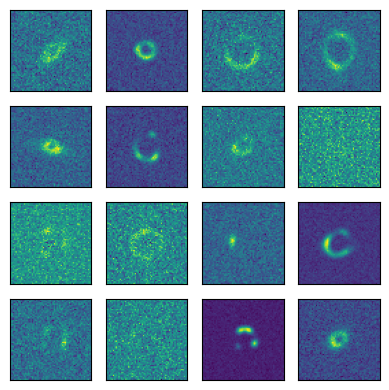

Plotting from npy files


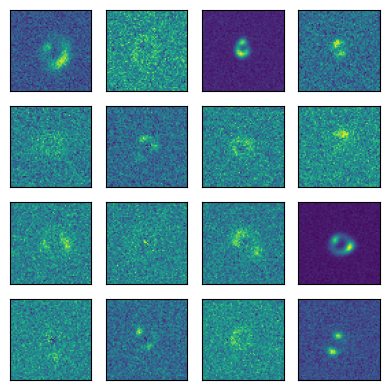

In [8]:
plot_collage('/mnt/extraspace/hollowayp/paltas_data/Example_SL_10/validation/1',4,4)
plot_collage('/mnt/extraspace/hollowayp/paltas_data/individual_systems/SL_2/',4,4)
